## Power Forecasting in a Windmill

A customer has set up a renewable energy farm and has several sensors ranging from capturing winds in the turbines to converting mechanical energy into electrical energy. For that, he would like a forecast for the next 7 days of the average power that a wind turbine can generate, in order to know if it will meet its weekly production target. 

### Action plan:

- Comprehension of the technology and statistical analysis of the sensors;
- Exploratory Analysis through the dataset, in order to find some problems and insights
- Data preparation for Machine Learning models
- Evaluation of the error
- Deployment using Database and Metabase as visualization tool

## Data Dictionarity

- Unnamed: 0: Timestamp sampled with period interval of 10 minutes.
- ActivePower: Active power generated by the windmill.
- AmbientTemperatue: Ambient temperature.
- BearingShaftTemperature: Bearing shaft temperature of the motor.
- Blade1PitchAngle: pitch angle of the wind turbine blade 1.
- Blade2PitchAngle: pitch angle of the wind turbine blade 2.
- Blade3PitchAngle: pitch angle of the wind turbine blade 3.
- ControlBoxTemperature: temperature of wind turbine control.
- GearboxBearingTemperature: Gearbox Bearing Temperature of the motor.
- GearboxOilTemperature: Gearbox Oil Temperature of the motor.
- GeneratorRPM: Measured RPM of the generator.
- GeneratorWinding1Temperature: Temperature of the winding in the generator 1.
- GeneratorWinding2Temperature: Temperature of the winding in the generator 2.
- HubTemperature: Temperature of Hub computer that control pitching of blades.
- MainBoxTemperature: Temperature of main box.
- NacellePosition: Position of the nacelle.
- ReactivePower: Reactive power generated by the windmill.
- RotorRPM: RPM of the rotor.
- TurbineStatus: Status of the turbine.
- WTG: Indicates that mechanical energy is instead converted to electricity, only G01.
- WindDirection: Wind direction in degrees. 
- WindSpeed: Wind speed in km/h.


## 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import datetime
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from IPython.display import Image

### 0.1 Helper Functions

In [2]:
# Function that converts camel style to snake style
def camel_to_snake(s):
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [3]:
# Function that calculate  the descriptive statistics
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [4]:
# Function that put the information of values inside the graphic
def label_graph(ax, fmt):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), fmt), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

In [5]:
def find_outliers(df, col_name):
    # Calculates Q1, Q3 and IQR
    Q1 = np.quantile(df[col_name], 0.25)
    Q3 = np.quantile(df[col_name], 0.75)
    IQR = Q3 - Q1

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = Q1 - 1.5 * IQR
    high_outliers = Q3 + 1.5 * IQR

    print('Outliers limit for {}:'.format(col_name))
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")
    
    return low_outliers, high_outliers

In [6]:
# Function to calculate MAE
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
# Function to calculate MAPE
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))
# Function that calculates MAE, MAPE and RMSE
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

In [199]:
# Function to train the model using cross validation
def cross_validation(x_training, selected_features, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Date that will start the validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*7)

        # Filter the dataset and split it in train and test
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] < validation_end_date)]

        # Drop columns for training
        xtraining = training[selected_features]
        ytraining = training['active_power']

        # Drop columns for validation
        xvalidation = validation[selected_features]
        yvalidation = validation['active_power']

        # ML Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, mms.inverse_transform([yvalidation]),  mms.inverse_transform([yhat]))

        # Performance for each metric
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( { 'Model': [model_name],
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

### 0.2 Loading Data

In [8]:
# Load the dataset of historical data
df0 = pd.read_csv('../data/Turbine_Data.csv')

In [9]:
# Show the first 5 elements
df0.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


## 1.0 Data Description

Describing data is important in this section for better comprehension of the dataset. Also, by using Descriptive Statistics,  it is possible to describe data through methods such as graphical representations, measures of central tendency and measures of variability. It summarizes the data in a meaningful way which enables us to find some outliers or even inconsistencies in data.

In [10]:
df1 = df0.copy()

### 1.1 Rename Columns

In [11]:
# Rename timestamp column 
df1 = df1.rename(columns={'Unnamed: 0': 'Date'})

In [12]:
# Convert the camel case to snake case
cols_old = ['Date', 'ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature','Blade1PitchAngle', 'Blade2PitchAngle', 
            'Blade3PitchAngle', 'ControlBoxTemperature', 'GearboxBearingTemperature','GearboxOilTemperature', 
            'GeneratorRPM', 'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature', 'HubTemperature',
            'MainBoxTemperature','NacellePosition', 'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG',
            'WindDirection', 'WindSpeed']

snake_case = lambda x: camel_to_snake(x)

cols_new = list(map(snake_case, cols_old))

df1.columns = cols_new

# Correction after snake transformation
cols_to_correct = ['generator_r_p_m', 'rotor_r_p_m', 'w_t_g']
cols_corrected = ['generator_rpm', 'rotor_rpm', 'wtg']

df1 = df1.rename(columns={'generator_r_p_m': 'generator_rpm',
                         'rotor_r_p_m': 'rotor_rpm',
                         'w_t_g': 'wtg'})

### 1.2 Data Dimensions

In [13]:
# Print the number of examples and features
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 118224
Number of columns: 22


### 1.3 Data Types

In [14]:
# Show the type of each column
df1.dtypes

date                               object
active_power                      float64
ambient_temperatue                float64
bearing_shaft_temperature         float64
blade1_pitch_angle                float64
blade2_pitch_angle                float64
blade3_pitch_angle                float64
control_box_temperature           float64
gearbox_bearing_temperature       float64
gearbox_oil_temperature           float64
generator_rpm                     float64
generator_winding1_temperature    float64
generator_winding2_temperature    float64
hub_temperature                   float64
main_box_temperature              float64
nacelle_position                  float64
reactive_power                    float64
rotor_rpm                         float64
turbine_status                    float64
wtg                                object
wind_direction                    float64
wind_speed                        float64
dtype: object

**Observations**:
- date is a object and not datetime.

In [15]:
# Convert date column from string to datetime
df1['date'] = pd.to_datetime(df1['date'])

### 1.4 Checking Missing Values

In [16]:
# Shows the percentage of missing values
100* df1.isna().sum() / len(df1)

date                               0.000000
active_power                      19.855528
ambient_temperatue                20.644708
bearing_shaft_temperature         47.119028
blade1_pitch_angle                64.477602
blade2_pitch_angle                64.566416
blade3_pitch_angle                64.566416
control_box_temperature           47.421843
gearbox_bearing_temperature       47.100420
gearbox_oil_temperature           47.186696
generator_rpm                     47.307653
generator_winding1_temperature    47.196001
generator_winding2_temperature    47.177392
hub_temperature                   47.213764
main_box_temperature              47.128333
nacelle_position                  38.863513
reactive_power                    19.857220
rotor_rpm                         47.449756
turbine_status                    46.789146
wtg                                0.000000
wind_direction                    38.863513
wind_speed                        19.986636
dtype: float64

**Observations**:
- It was found a large number of missing values, representing 64.56% of the dataset in some features;
- There are some strategies that we can handle: Drop the columns with expressive missing values; Replace it by the mean/median; Moving average; Replace with the last or next value non-null.
- For this problem, I am going to use the method ffill and bfill from pandas, which propagates the last non-null value in backward and forward direction.


### 1.5 Replace NaN values

In [17]:
# Replace NaN values by propagating forward and backward the last value non-null
df1 = df1.fillna(method='ffill').fillna(method='bfill')

In [18]:
# Shows the percentage of missing values
100* df1.isna().sum() / len(df1)

date                              0.0
active_power                      0.0
ambient_temperatue                0.0
bearing_shaft_temperature         0.0
blade1_pitch_angle                0.0
blade2_pitch_angle                0.0
blade3_pitch_angle                0.0
control_box_temperature           0.0
gearbox_bearing_temperature       0.0
gearbox_oil_temperature           0.0
generator_rpm                     0.0
generator_winding1_temperature    0.0
generator_winding2_temperature    0.0
hub_temperature                   0.0
main_box_temperature              0.0
nacelle_position                  0.0
reactive_power                    0.0
rotor_rpm                         0.0
turbine_status                    0.0
wtg                               0.0
wind_direction                    0.0
wind_speed                        0.0
dtype: float64

### 1.6 Descriptive Statistics

In [19]:
# Split the dataset in numerical and categorical
num_attributes = df1.select_dtypes(include = ['float64'])
cat_attributes = df1.select_dtypes(exclude = ['float64', 'datetime64[ns]'])

#### 1.6.1 Numerical Attributes

In [20]:
# Calculate the statistics
descriptive_analysis(num_attributes)

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,active_power,639.934548,423.445880,630.141658,-38.524659,1.779032e+03,1.817557e+03,0.648454,-1.082583
1,ambient_temperatue,28.574250,28.126315,4.308102,0.000000,4.240560e+01,4.240560e+01,0.281966,0.811206
2,bearing_shaft_temperature,44.966830,47.901936,6.404004,0.000000,5.508866e+01,5.508866e+01,-3.534934,20.653067
3,blade1_pitch_angle,31.797893,45.736893,22.150311,-43.156734,9.014361e+01,1.333003e+02,-0.436169,-0.989127
4,blade2_pitch_angle,30.718228,43.699357,21.173457,-26.443415,9.001783e+01,1.164612e+02,-0.366678,-0.828616
5,blade3_pitch_angle,30.718228,43.699357,21.173457,-26.443415,9.001783e+01,1.164612e+02,-0.366678,-0.828616
6,control_box_temperature,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
7,gearbox_bearing_temperature,68.885245,75.066281,11.675754,0.000000,8.223793e+01,8.223793e+01,-2.404865,9.730579
8,gearbox_oil_temperature,60.146597,63.304417,5.812920,0.000000,7.076458e+01,7.076458e+01,-1.396449,3.684245
9,generator_rpm,1359.868503,1691.274462,527.575804,0.000000,1.809942e+03,1.809942e+03,-1.351028,0.830080


**Observations**:

- **active_power** has an average of 639.93 KW and it reaches a maximum value of 1.78 MW. The variable has low skew and kurtosis, it may follow a normal distribution.
- **ambient_temperature** may follow a normal distribution and the average value is 28.56 ºC.
- **bearing_shaft_temperature** has a range of 55 ºC, and its average is 44.96 ºC.
- All the **blade** features are similar, in which the blade 1 vary a little bit more than the others.
- **control_box_temperature** has no information, all the values are zero.
- **gearbox_bearing_temperature** is skewed compared to the other variables, and this may not follow a normal distribution. The range is 82.2 ºC and the median 75.06 ºC.
- **gearbox_oil_temperature** may follow the same distribution of gear box bearing temperature. 
- The maximum value of **generator_rpm** is 1809 RPM, while its minimum is zero (when it is off). The median value is 1691 RPM.
- **generator_winding_temperature 1 and 2** are similar, they may not follow a normal distribution and the maximum values reach 1260 ºC, which can indicate an outlier. 
- **hub_temperature** reaches 47.96 ºC with an average of 38.7 ºC.
- **main_box_temperature** is very similar to the hub temperature, but it reaches 54.25 ºC.
- **nacelle_position** has a range of degrees from 0 to 357º, with a median of 188º and an average of 201.71º.
- **reactive_power** has a minimum value of -203.18 VAr, which indicates a moment that the load is more capacitive. When the reactive power is positive, it means a inductive load. Mostly values are positive, it indicates a inductive load.
- **rotor_rpm** is very low compared to the generator. The average value is 12.19 RPM.
- **wind_direction** also has a range from 0 to 357º and the average value is 201.71º. 
- **wind_speed** may follow a normal distribution and the average value is 6.03 km/h, reaching the maximum value of 22.9 km/h.

#### 1.6.2 Categorical Attributes

- Only WTG is a categorical attribute and has no information contained in the variable. I will treat it later.

## 2.0 Filtering Data

This section is used to drop some columns that were analyzed in the previous sections and does not contain any information. This may be useful to reduce the model complexity.

In [21]:
df2 = df1.copy()

### 2.1 Filtering Rows

In [22]:
# Filter rows based on IQR method to find the outliers
cols_to_clean = ['active_power', 'ambient_temperatue', 'bearing_shaft_temperature', 'blade1_pitch_angle', 'blade2_pitch_angle', 'blade3_pitch_angle', 'gearbox_bearing_temperature', 'gearbox_oil_temperature', 'generator_rpm', 'generator_winding1_temperature', 'generator_winding2_temperature', 'hub_temperature', 'main_box_temperature', 'nacelle_position', 'reactive_power', 'rotor_rpm', 'turbine_status', 'wind_direction', 'wind_speed']

for col in cols_to_clean:
    # Find the low and high boundaries 
    low, high = find_outliers(df2, col)

    # Filter
    df2 = df2[(df2[col] >= low) & (df2[col] < high)]

Outliers limit for active_power:
Q1 = 70.59523496368422
Q3 = 1155.6266169649123
IQR = 1085.031382001228
low_outliers = -1556.9518380381578
high_outliers = 2783.173689966754
Outliers limit for ambient_temperatue:
Q1 = 25.5313385
Q3 = 31.261132142152263
IQR = 5.729793642152263
low_outliers = 16.936648036771608
high_outliers = 39.85582260538066
Outliers limit for bearing_shaft_temperature:
Q1 = 41.592835328571425
Q3 = 47.90193587500001
IQR = 6.309100546428581
low_outliers = 32.12918450892855
high_outliers = 57.36558669464288
Outliers limit for blade1_pitch_angle:
Q1 = 1.6585923473684212
Q3 = 45.7368925375
IQR = 44.07830019013158
low_outliers = -64.45885793782894
high_outliers = 111.85434282269736
Outliers limit for blade2_pitch_angle:
Q1 = 2.1403288375000002
Q3 = 43.69935714285714
IQR = 41.55902830535714
low_outliers = -60.198213620535704
high_outliers = 106.03789960089284
Outliers limit for blade3_pitch_angle:
Q1 = 2.1403288375000002
Q3 = 43.69935714285714
IQR = 41.55902830535714
low_out

### 2.1 Filtering Columns

In [23]:
# Drop the columns that does not contain information
cols_to_drop = ['wtg', 'control_box_temperature']

df2 = df2.drop(cols_to_drop, axis = 1)

## 3.0 Feature Engineering

Feature engineering involves leveraging data mining techniques to extract features from raw data along with the use of domain knowledge. Feature engineering is useful to improve the performance of machine learning algorithms and to better understand the dataset behaviour. Also, it is used a mind map with some hypothesis that can generate important insights to the engineer and answer the questions that were made in the beginning of the project.

In [24]:
df3 = df2.copy()

### 3.1 Hypothesis Mind Map

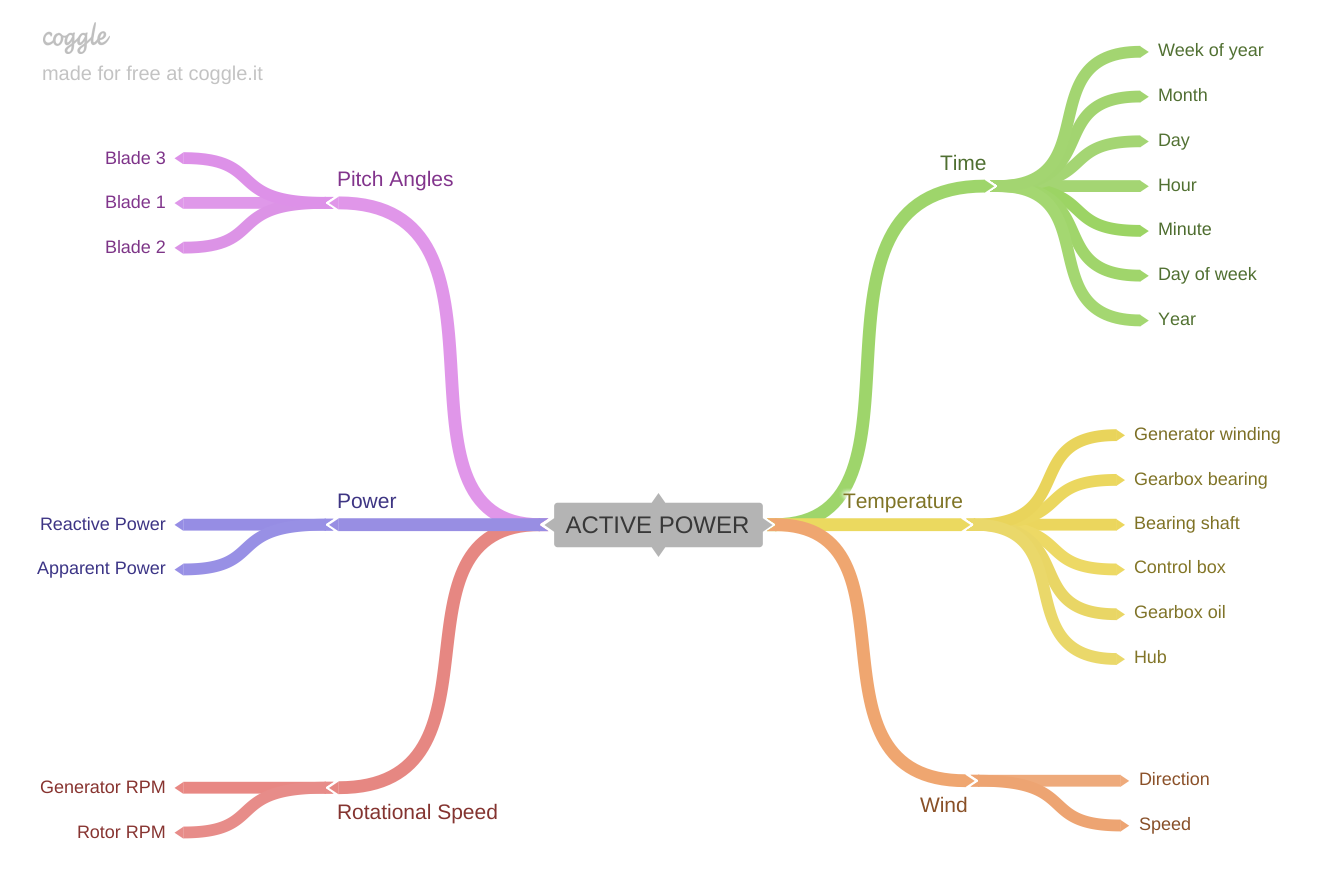

In [3]:
Image('../images/mind_map_hypothesis.png')

### 3.2 Hypothesis List

**H1** - From january to march, the windmill generates the largest active power.

**H2** - The active power produced in X and Y are similar.

**H3** - Higher the temperature of the gearbox bearing, higher the conversion to active power.

**H4** - Wind direction of 180º generates the highest value of active power.

**H5** - Higher the wind speed, higher the active power generation.

**H6** - Pitch angle between 0º and 30º is the optimal position for generate active power.

**H7** - Nacelle position misaligned with wind direction will generate less active power.

**H8** - Higher the Generator and Rotor RPM, higher the production of active power.

**H9** - The best hour for generation of power is in the night shift.

### 3.3 Creating New Features

In [26]:
# Extract Temporal Features
df3['day'] = df3['date'].dt.day
df3['minute'] = df3['date'].dt.minute
df3['hour'] = df3['date'].dt.hour
df3['day_of_week'] = df3['date'].dt.dayofweek
df3['day_of_year'] = df3['date'].dt.dayofyear
df3['week_of_year'] = df3['date'].dt.weekofyear
df3['month'] = df3['date'].dt.month
df3['year'] = df3['date'].dt.year


# Moving averages
# MA for 15 days
df3['avg_15d'] = df3['active_power'].rolling(24*6*15).mean()
# MA for 30 days
df3['avg_30d'] = df3['active_power'].rolling(24*6*30).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


## 4.0 Exploratory Data Analysis (EDA)

This section is used to understand the business and the dataset. It is the most important part to report some useful insights for the managers. To analyze it, I will consider 3 analysis:

Univariate - The distribution, countplot and boxplot of each variable. It is important to remove outliers further.

Bivariate - All the hypothesis can be answered in this subsection. It can analyze the impact of each feature in the target variable;

Multivariate - Important to remove colinearity.

In [27]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Target Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


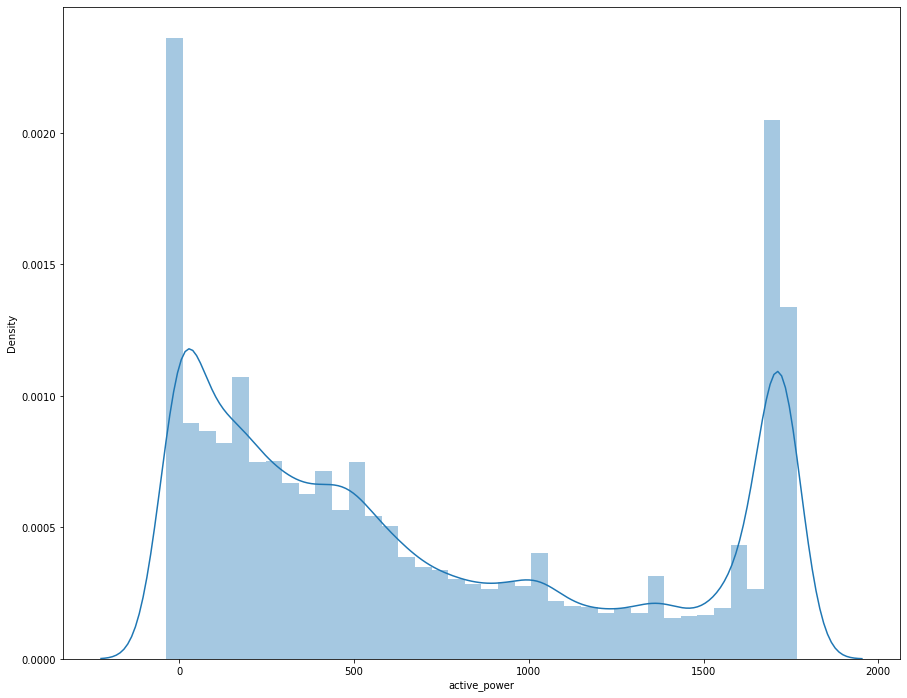

In [28]:
# Histogram of the  target variable
plt.figure(1, figsize=(15,12))
sns.distplot(df4['active_power'])

##### 4.4.1.1 Temporal Analysis

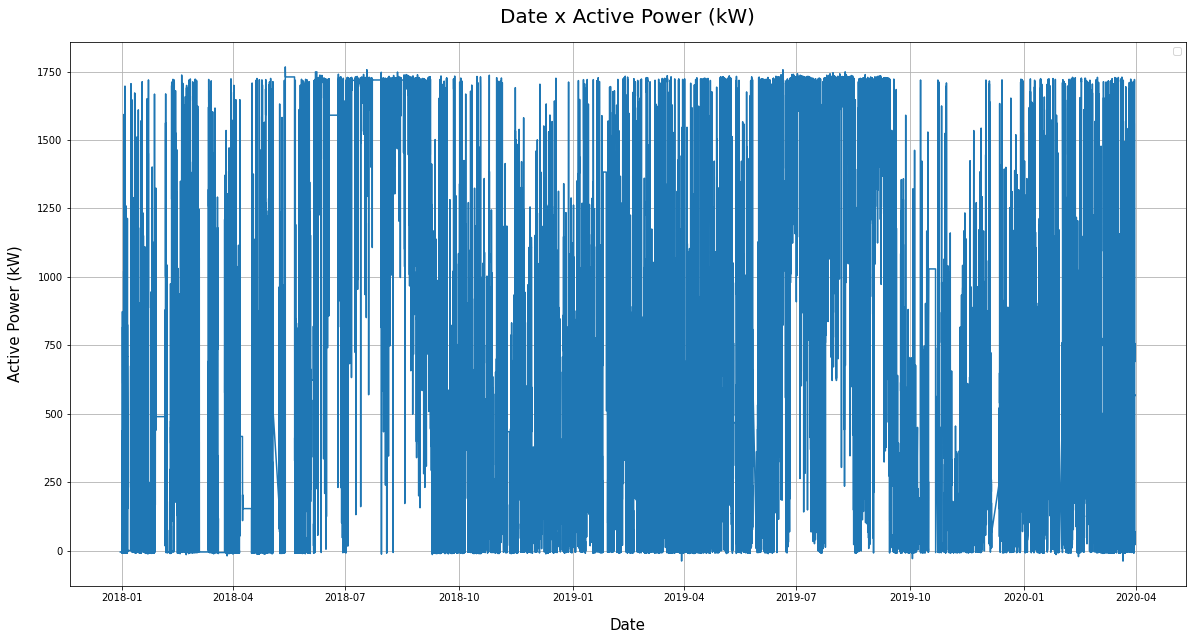

In [29]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(x = 'date', y = 'active_power', data = df4)

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Date x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.legend('')
ax.grid()




Since it is a time-series problem, to forecast properly, we need to know if the time-series is stationary or not. For doing this, we are going to apply the Augmented Dickey-Fuller test. 


-Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

-Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

-p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

-p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [30]:
test_result = adfuller(df4['active_power'].values)

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

ADF Statistic: -15.364882
p-value: 0.000000


**Observations**:
- The target variable does not follow a normal distribution, it is depicted a bimodal behaviour.
- This may suggest the dataset is non-stationary.

#### 4.1.2 Numerical Attributes

In [31]:
num_attributes = df4.select_dtypes(include = ['float64'])

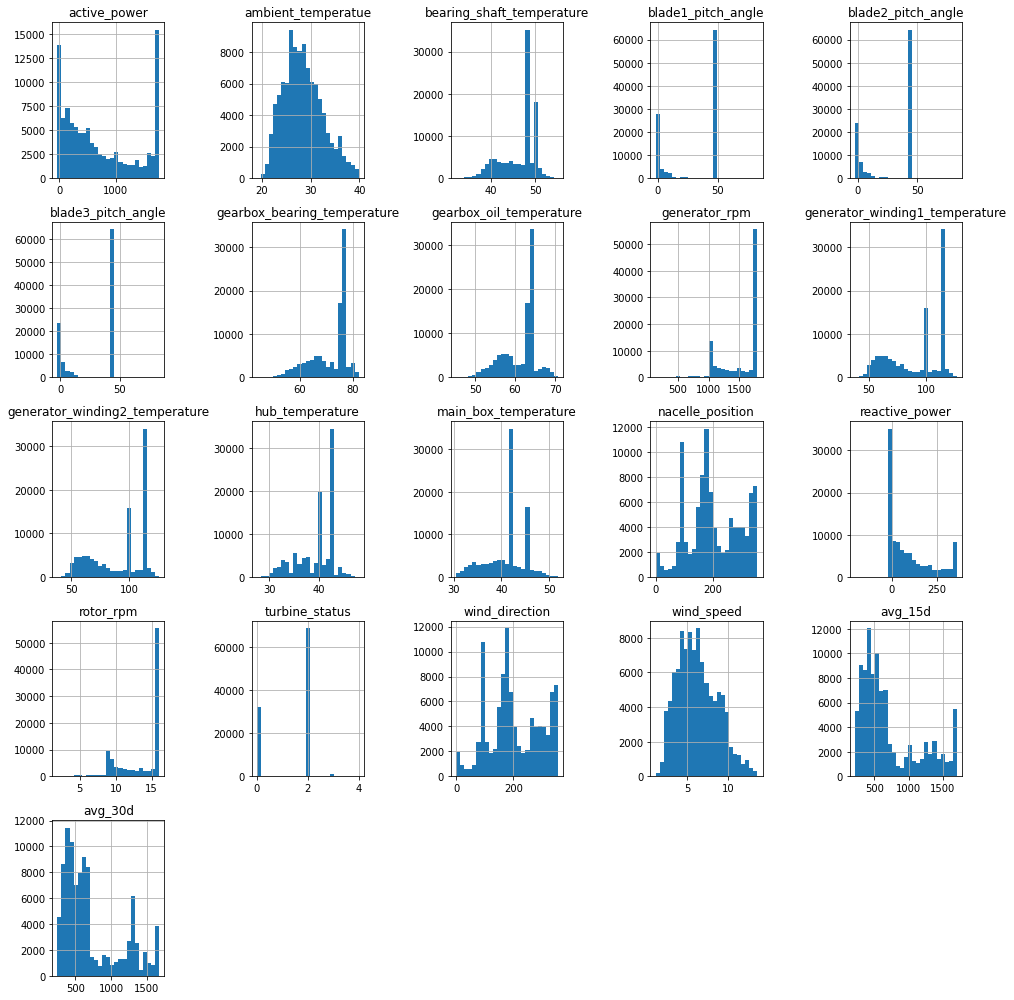

In [32]:
num_attributes.hist(bins = 25, figsize = (14,14))
plt.tight_layout()

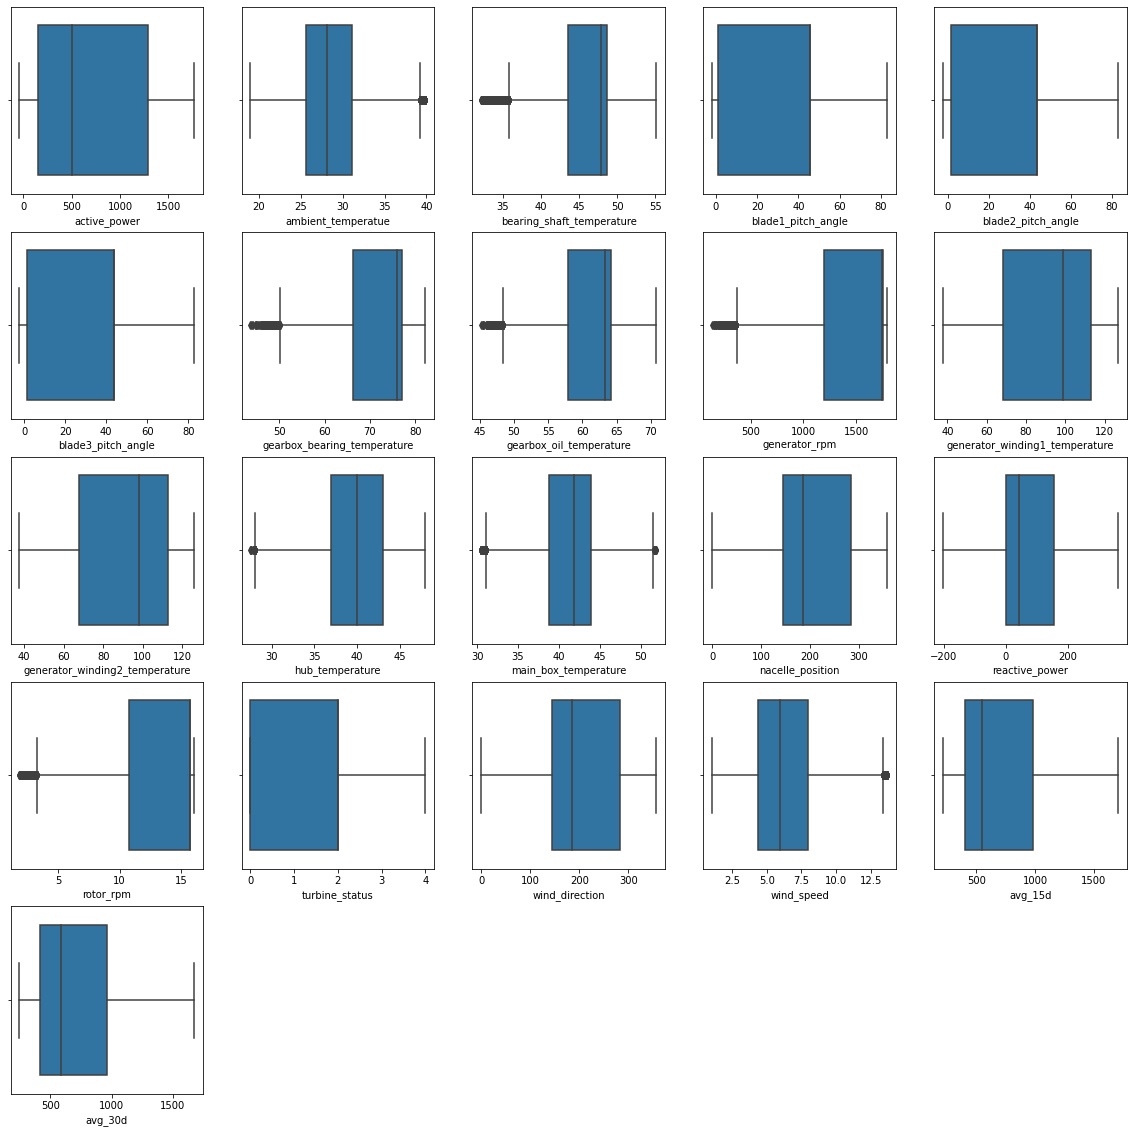

In [33]:
plt.figure(1, figsize = (20,20))
for i, col in enumerate(num_attributes.columns):
    plt.subplot(5, 5, i+1)
    sns.boxplot(x = num_attributes[col])

**Observations**:
- As seen above, most variables have more than a peak in the pdf;
- The outliers were filtred before by using IQR method.

### 4.2 Bivariate Analysis

**H1** - From january to march, the windmill generates the largest active power.


**FALSE**: The best months of the year for the power generation is between June and August.

In [34]:
aux = df4.groupby('month')['active_power', 'wind_speed'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


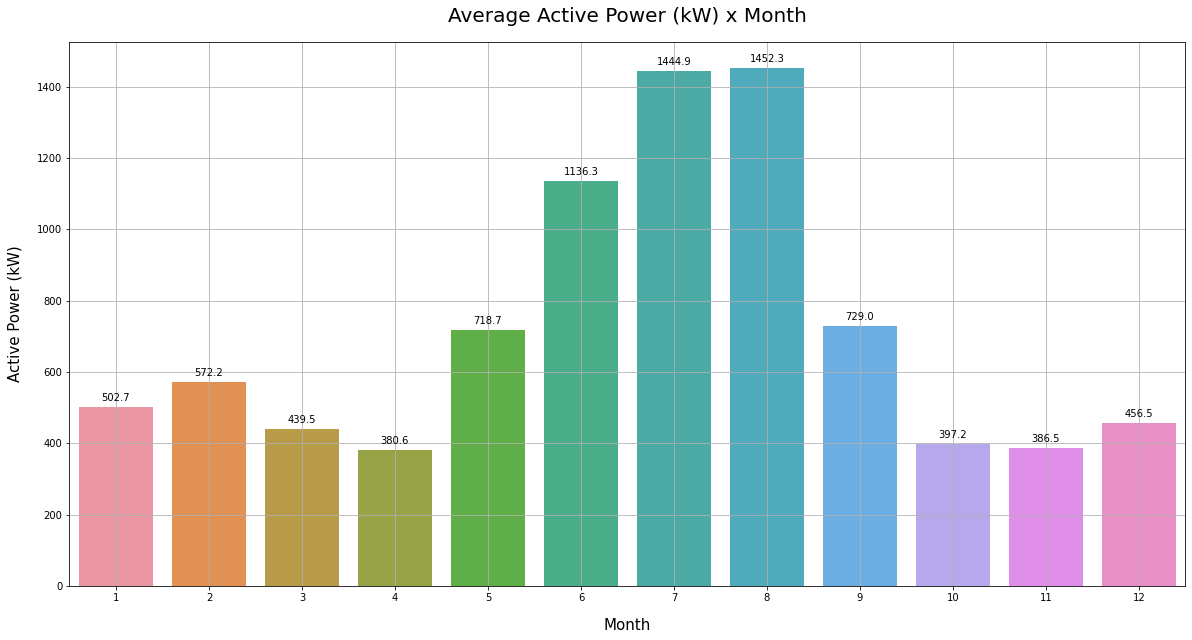

In [35]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Barplot of active power 
ax = sns.barplot(ax= ax, x= aux['month'], y= aux['active_power'])

label_graph(ax, '.1f')
# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Month", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.grid()



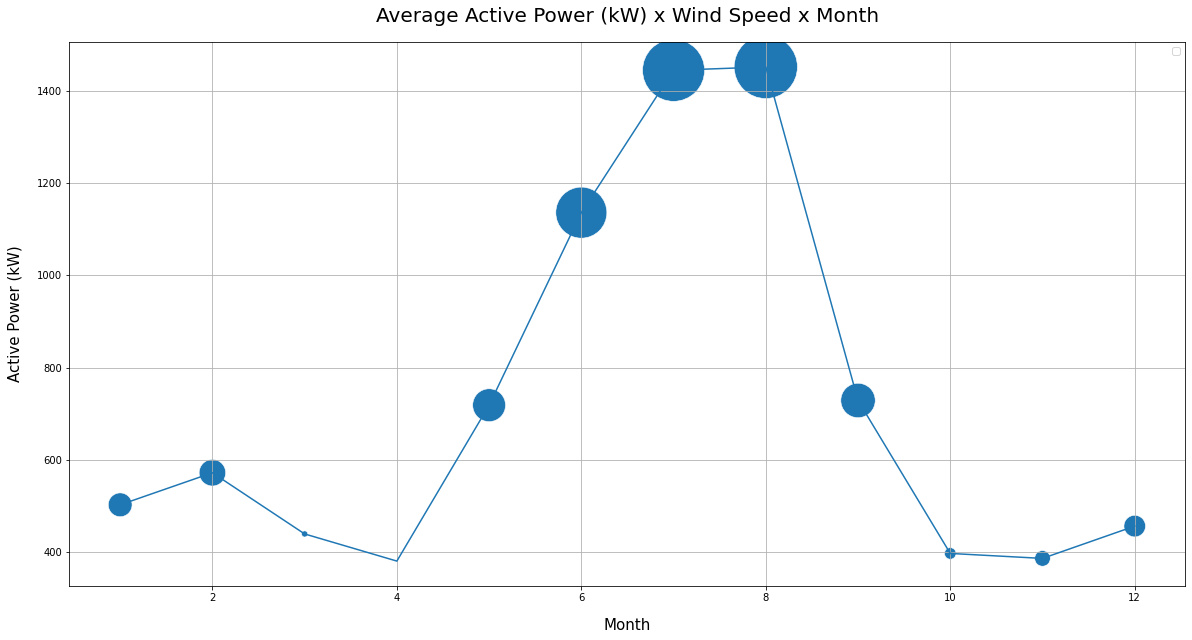

In [36]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(ax= ax, x= aux['month'], y= aux['active_power'])

sns.scatterplot(ax= ax, x= aux['month'], y= aux['active_power'], size= aux['wind_speed'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Wind Speed x Month", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.legend('')
ax.grid()




**H2** - The average active power produced in 2018, 2019 and are similar.



**FALSE**: The average of active power produced in 2018 is higher than 2019 and 2020. But, there are less registers in 2020.

In [37]:
aux = df4.groupby('year')['active_power', 'wind_speed'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [38]:
df4.groupby('year')['active_power', 'wind_speed'].count().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,year,active_power,wind_speed
0,2017,144,144
1,2018,50563,50563
2,2019,40596,40596
3,2020,10901,10901


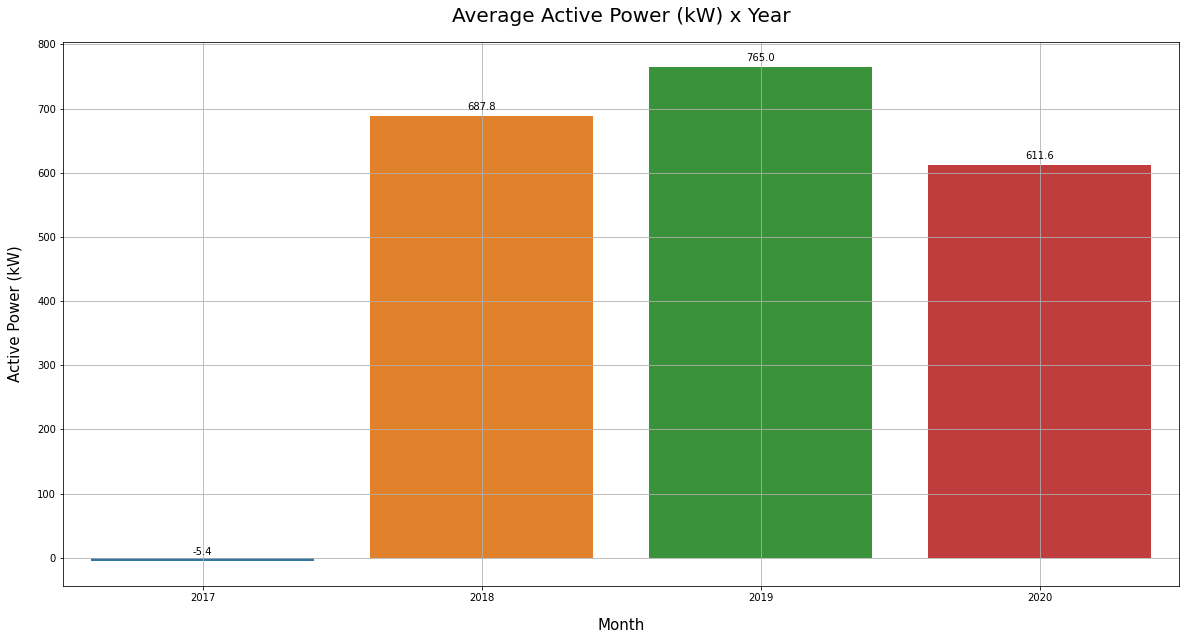

In [39]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Barplot of active power 
ax = sns.barplot(ax= ax, x= aux['year'], y= aux['active_power'])

label_graph(ax, '.1f')
# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Year", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.grid()




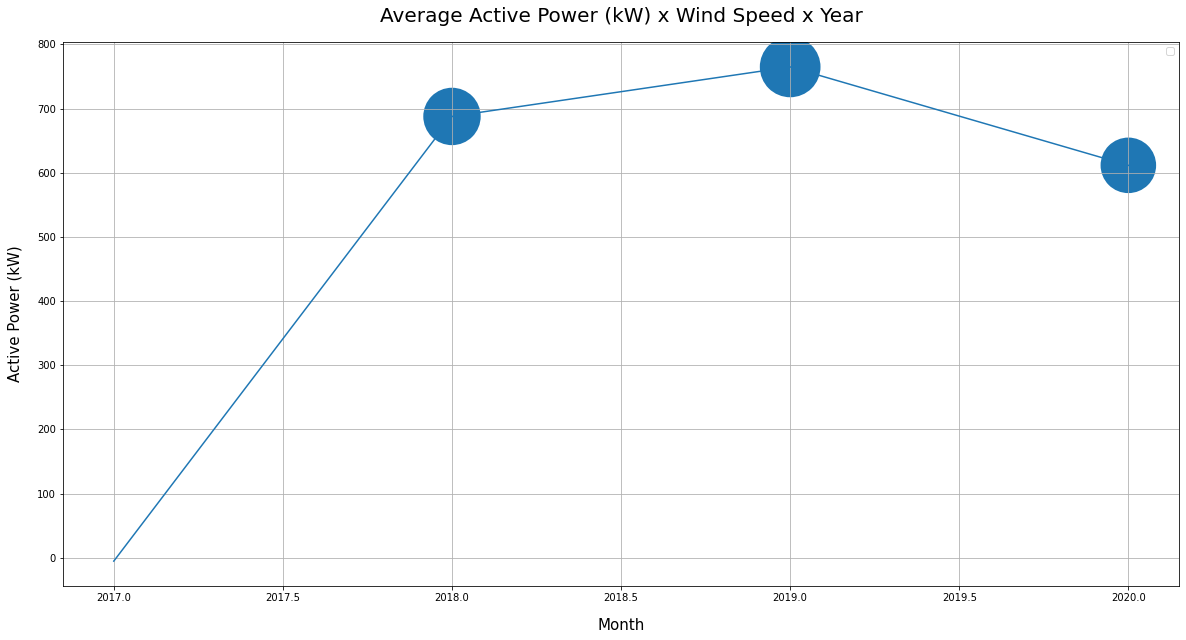

In [40]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(ax= ax, x= aux['year'], y= aux['active_power'])

#Scatterplot of Wind Speed with size based on the speed
sns.scatterplot(ax= ax, x= aux['year'], y= aux['active_power'], size= aux['wind_speed'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Wind Speed x Year", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.legend('')
ax.grid()



**H3** - Higher the temperature of the gearbox bearing, higher the conversion to active power.

**TRUE**: There is a relation between the gearbox bearing and the active power.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


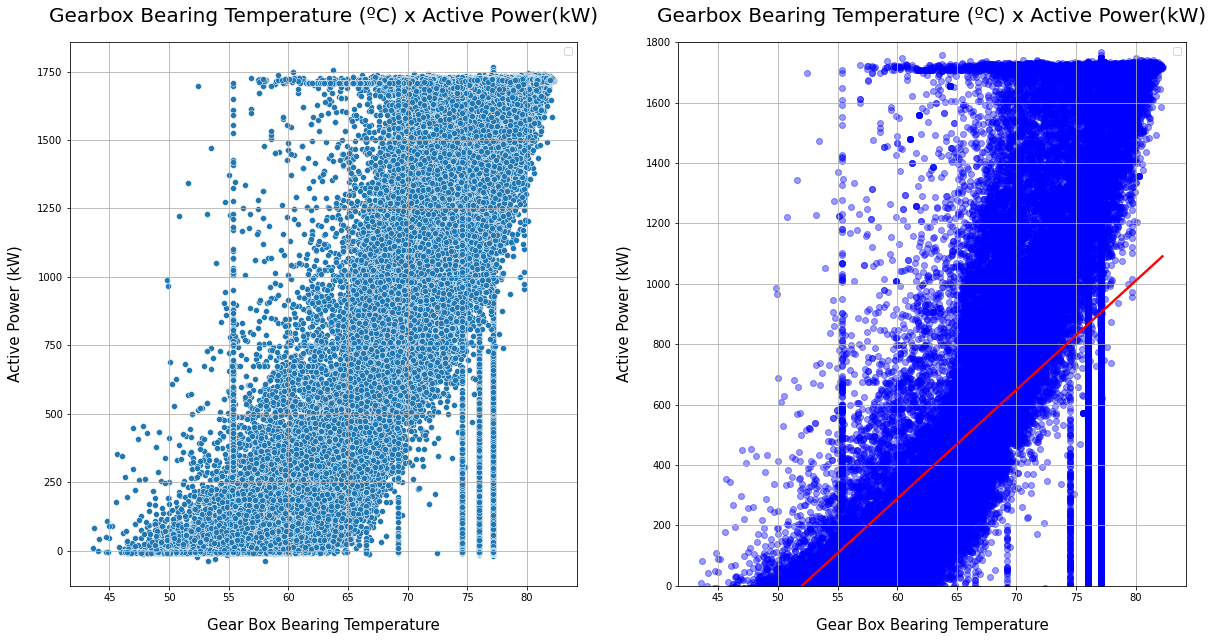

In [41]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(1,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['gearbox_bearing_temperature'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Gearbox Bearing Temperature (ºC) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Gear Box Bearing Temperature", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(1,2,2)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.regplot(df4['gearbox_bearing_temperature'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Gearbox Bearing Temperature (ºC) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Gear Box Bearing Temperature", size= 15, labelpad= 15)
ax.legend('')
ax.set_ylim([0, 1800])
ax.grid()


**H4** - Wind direction of 180º generates the highest value of active power.


**FALSE**: The wind direction analyzed alone does not seen to affect the active power.

In [42]:
# Groupby wind direction and extract the average power
aux = df4[['wind_direction', 'active_power']]
aux['wind_direction'] = aux['wind_direction'].round()
aux2 = aux.groupby(['wind_direction'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['wind_direction'].values, 'radius': np.cos(np.pi*aux2['wind_direction'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


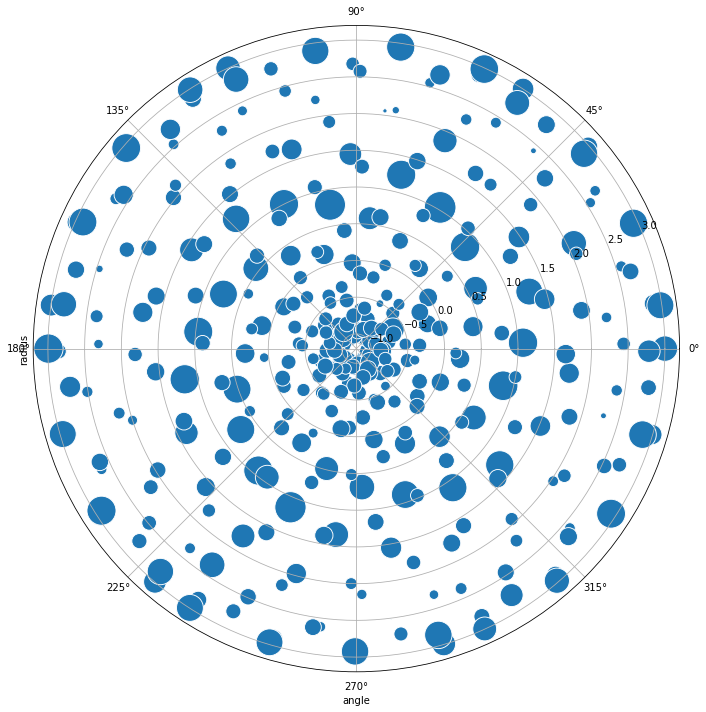

In [43]:
### Make the polar plot
g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**H5** - Faster the wind speed, higher the active power generation.



**TRUE**: Faster the wind speed, the baldes will rotater faster and more electrical power from the generator is converted. However, this increase is limited between 2.5 m/s and 8.5 m/s, after this range, the velocity can increase and the active power will keep constant.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


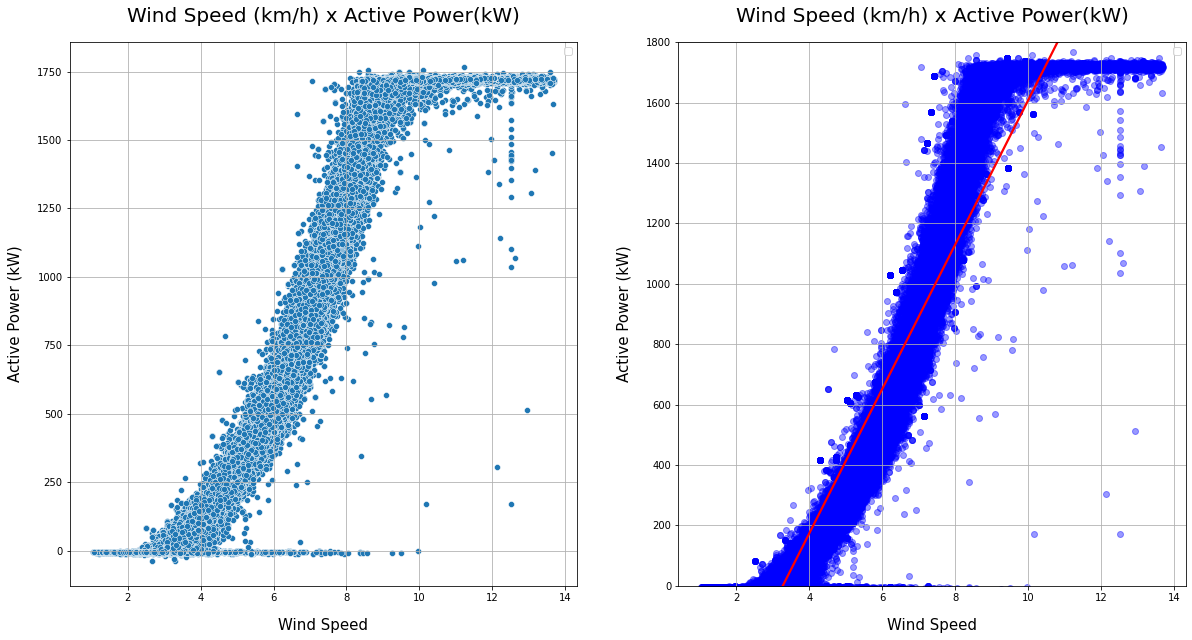

In [44]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(1,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['wind_speed'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Wind Speed (km/h) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Wind Speed", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(1,2,2)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.regplot(df4['wind_speed'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Wind Speed (km/h) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Wind Speed", size= 15, labelpad= 15)
ax.legend('')
ax.set_ylim([0, 1800])
ax.grid()


**H6** - Active power is constant at any pitch angle.



**BLADE 1**

In [45]:
# Groupby wind direction and extract the average power
aux = df4[['blade1_pitch_angle', 'active_power']]
aux['blade1_pitch_angle'] = aux['blade1_pitch_angle'].round()
aux2 = aux.groupby(['blade1_pitch_angle'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['blade1_pitch_angle'].values, 'radius': np.cos(np.pi*aux2['blade1_pitch_angle'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


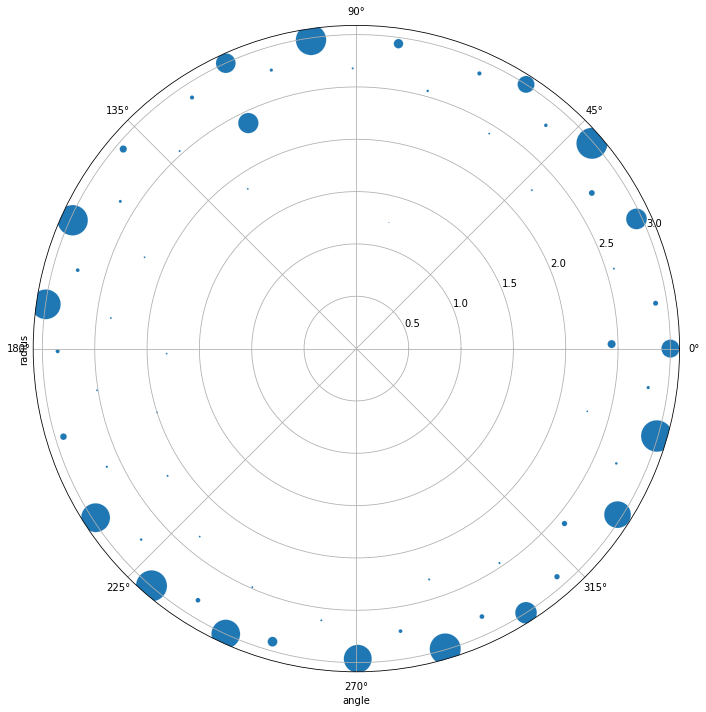

In [46]:
### Make the polar plot

g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**BLADE 2**

In [47]:
# Groupby wind direction and extract the average power
aux = df4[['blade2_pitch_angle', 'active_power']]
aux['blade2_pitch_angle'] = aux['blade2_pitch_angle'].round()
aux2 = aux.groupby(['blade2_pitch_angle'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['blade2_pitch_angle'].values, 'radius': np.cos(np.pi*aux2['blade2_pitch_angle'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


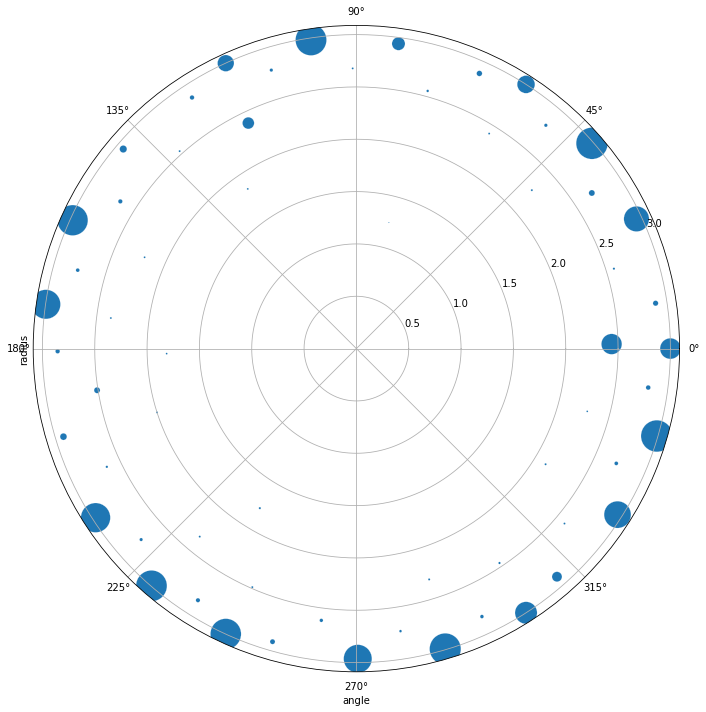

In [48]:
### Make the polar plot

g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**BLADE 3**

In [49]:
# Groupby wind direction and extract the average power
aux = df4[['blade3_pitch_angle', 'active_power']]
aux['blade3_pitch_angle'] = aux['blade3_pitch_angle'].round()
aux2 = aux.groupby(['blade3_pitch_angle'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['blade3_pitch_angle'].values, 'radius': np.cos(np.pi*aux2['blade3_pitch_angle'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


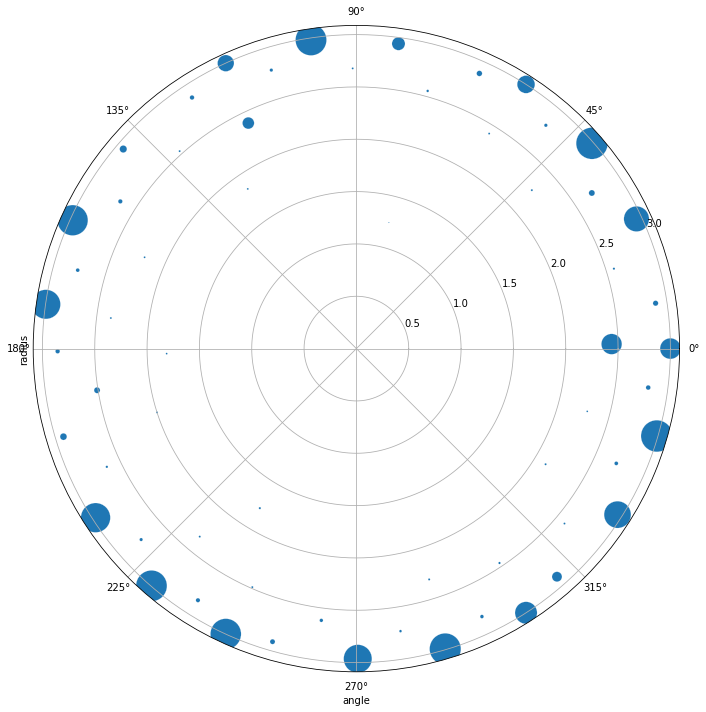

In [50]:
### Make the polar plot

g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**H7** - If the nacelle position is misalligned to the wind direction, it will generate less power. If alligned, it does not affect the conversion.


**TRUE**: The nacelle is always alligned to the wind direction, then the conversion of active power is not impacted.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


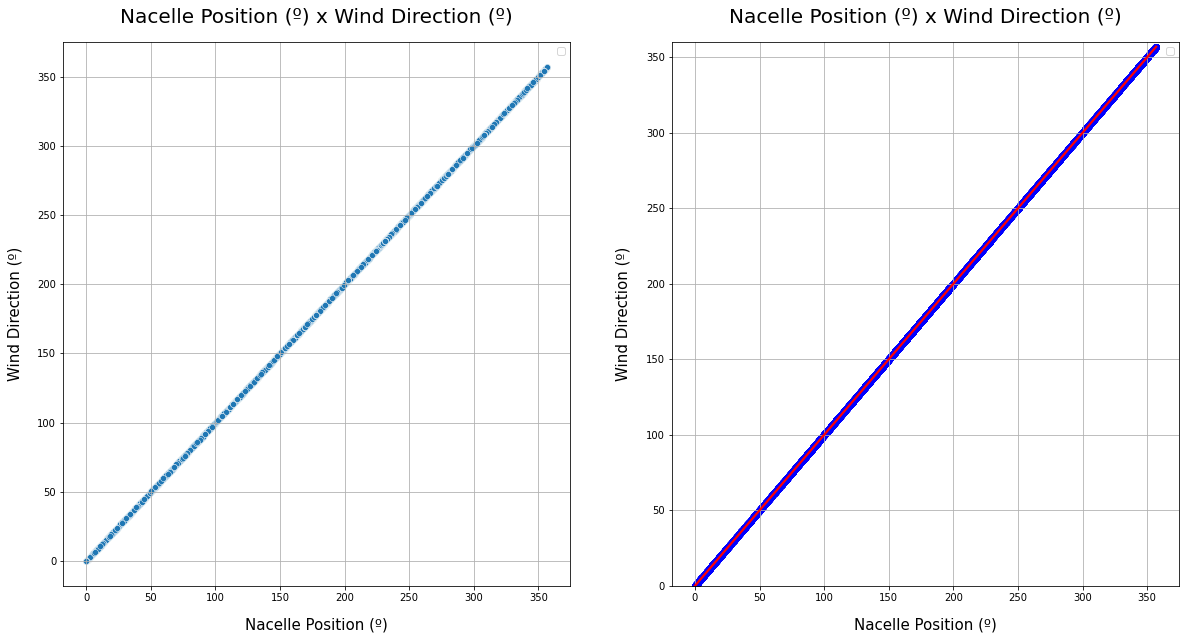

In [51]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(1,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['nacelle_position'], df4['wind_direction'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Nacelle Position (º) x Wind Direction (º)", size= 20, pad= 20)
ax.set_ylabel("Wind Direction (º)", size= 15, labelpad= 15)
ax.set_xlabel("Nacelle Position (º)", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(1,2,2)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.regplot(df4['nacelle_position'], df4['wind_direction'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Nacelle Position (º) x Wind Direction (º)", size= 20, pad= 20)
ax.set_ylabel("Wind Direction (º)", size= 15, labelpad= 15)
ax.set_xlabel("Nacelle Position (º)", size= 15, labelpad= 15)
ax.legend('')
ax.set_ylim([0, 360])
ax.grid()


In [52]:
aux = df4[['nacelle_position', 'wind_direction', 'active_power']]
aux['misalignment'] = aux['nacelle_position'] - aux['wind_direction']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


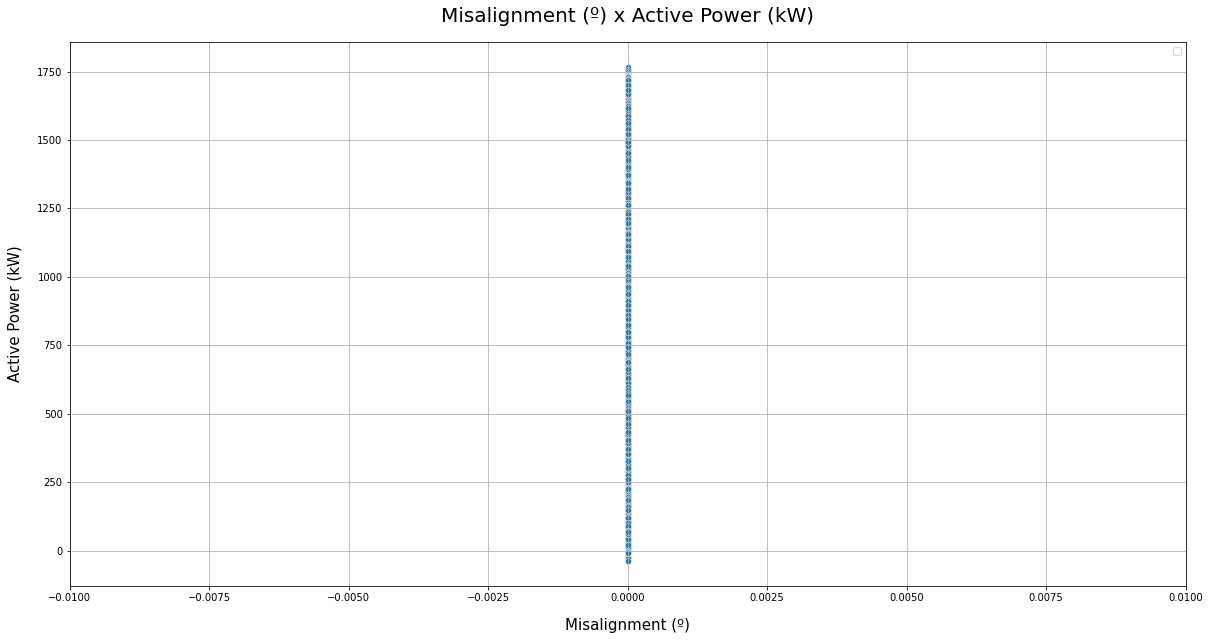

In [53]:
# Create the figure
plt.figure(1, figsize = (20,10))

ax = sns.scatterplot(aux['misalignment'], aux['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Misalignment (º) x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Misalignment (º)", size= 15, labelpad= 15)
ax.legend('')
ax.set_xlim([-0.01,0.01])
ax.grid()



**H8** - Higher the Generator and Rotor RPM, higher the production of active power.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

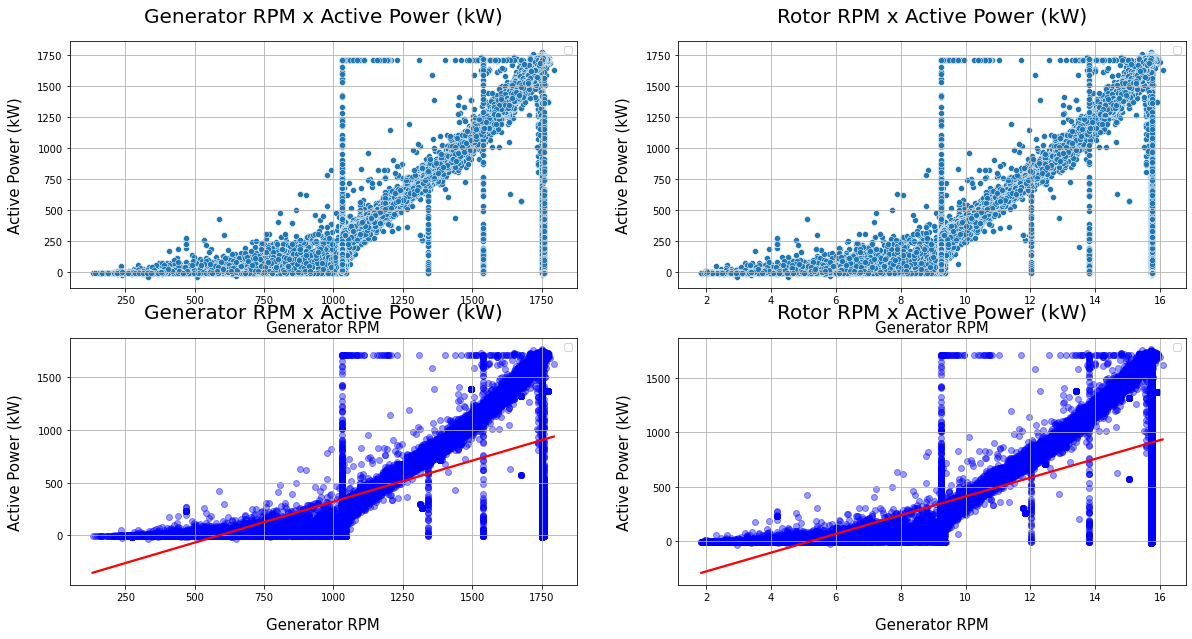

In [54]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(2,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['generator_rpm'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Generator RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(2,2,2)
# Lineplot of active power and the relation with rotor rpm and active power
ax = sns.scatterplot(df4['rotor_rpm'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Rotor RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()


plt.subplot(2,2,3)
# regression of active power and generator rpm 
ax = sns.regplot(df4['generator_rpm'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})


# setting ax graph, title, labels, ticks and sizes
ax.set_title("Generator RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(2,2,4)
# regression of active power and rotor rpm 
ax = sns.regplot(df4['rotor_rpm'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})


# setting ax graph, title, labels, ticks and sizes
ax.set_title("Rotor RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()




**H9** - The best hour for generation of power is in the night shift.

**FALSE**: The best hours for conversion of mechanical energy in electrical energy are between 13h and 19h.

In [55]:
aux = df4.groupby('hour')['active_power', 'wind_speed'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


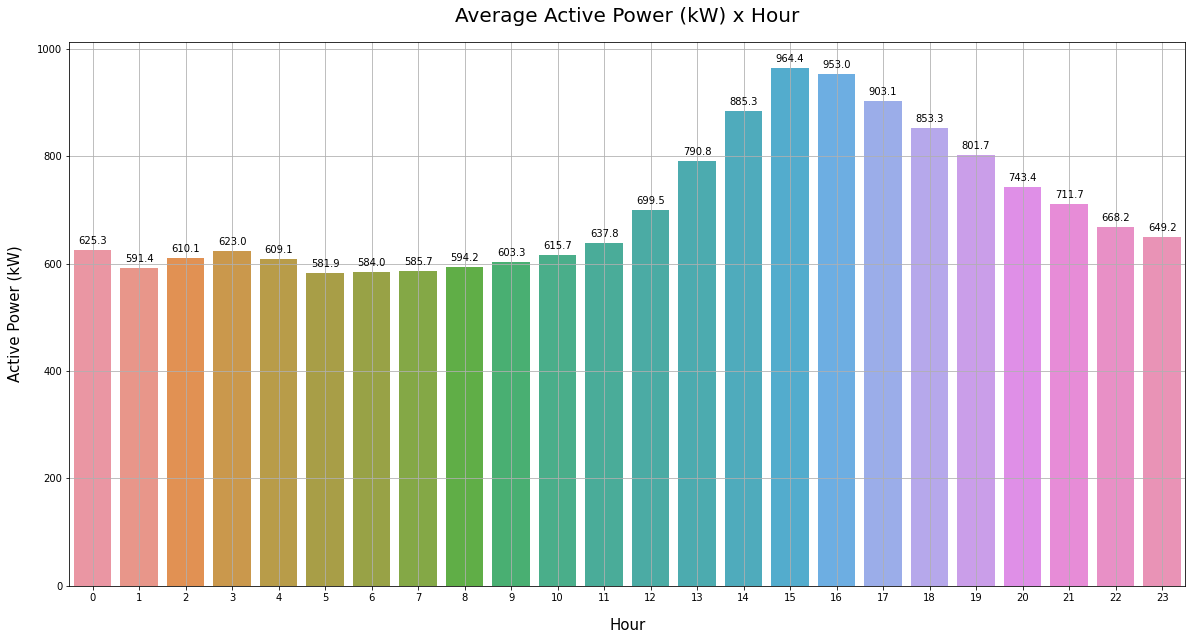

In [56]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Barplot of active power 
ax = sns.barplot(ax= ax, x= aux['hour'], y= aux['active_power'])

label_graph(ax, '.1f')
# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Hour", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Hour", size= 15, labelpad= 15)
ax.grid()




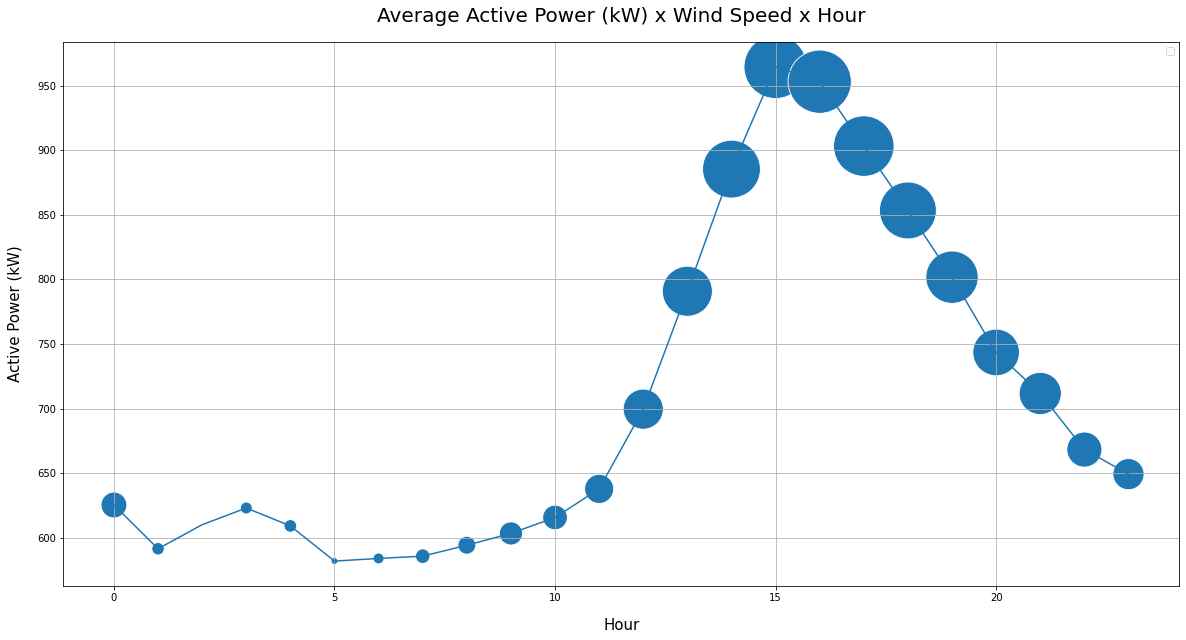

In [57]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(ax= ax, x= aux['hour'], y= aux['active_power'])

#Scatterplot of Wind Speed with size based on the speed
sns.scatterplot(ax= ax, x= aux['hour'], y= aux['active_power'], size= aux['wind_speed'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Wind Speed x Hour", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Hour", size= 15, labelpad= 15)
ax.legend('')
ax.grid()



### 4.3 Multivariate Analysis

#### 4.3.1 Numerical Attributes

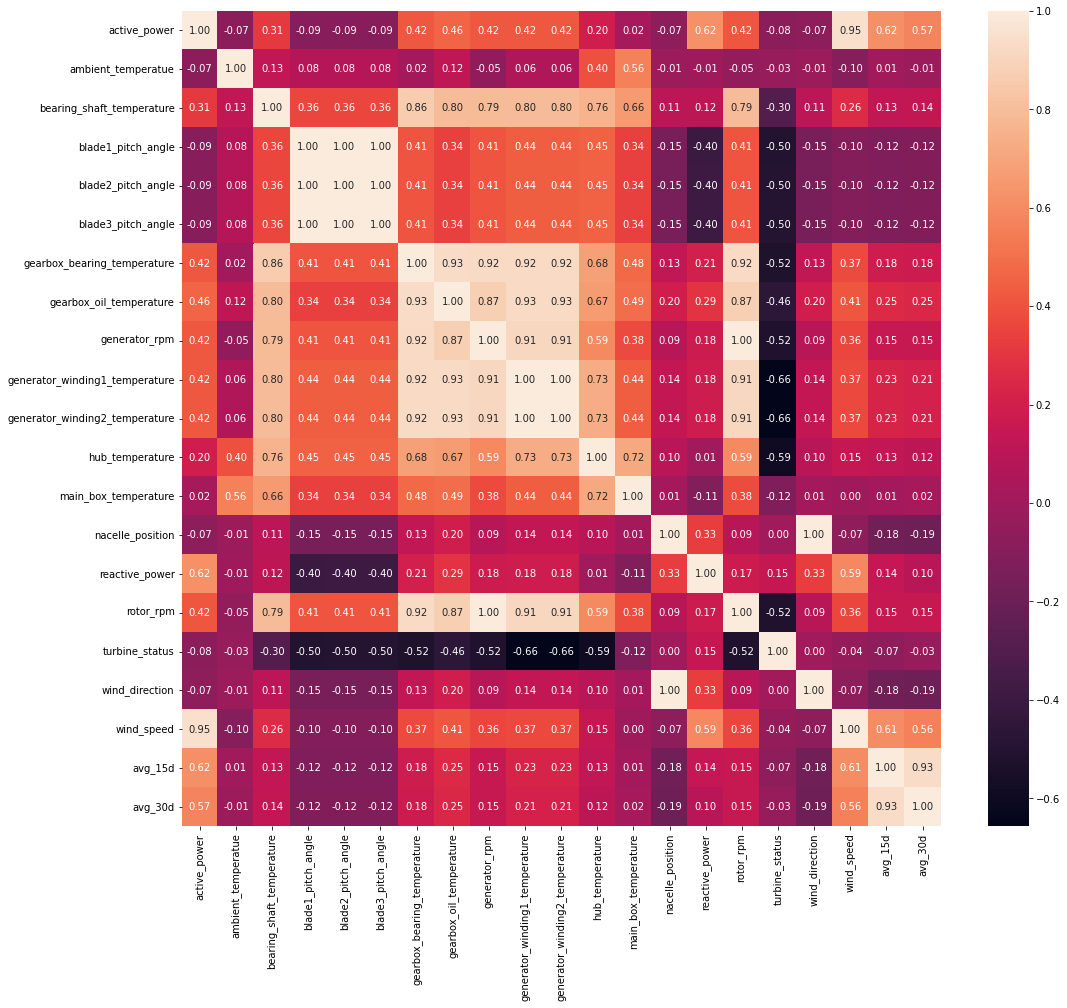

In [58]:
# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a correlation matrix from numerical dataframe
corr_matrix = num_attributes.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre_num' as data
sns.heatmap(corr_matrix, annot = True, fmt= '.2f')

**Observations**:
- the blades' pitch angles are colinear, then it can be represented by one variable only;
- primary and secundary winding of the generator are colinear too;
- nacelle position and wind direction have the same value, then is colinear.
- rotor and generator has the same rpm multiplied by a factor, then can be considered colinear too;

**Good correlations**:
- wind_speed x active_power (0.87)
- reactive_power x active_power (0.66)
- gearbox_oil_temperature x active_power (0.52)
- gearbox_bearing_temperature x active_power (0.42)
- generator_winding1_temperature x active_power (0.51)
- generator_rpm x active_power (0.5)

## 5.0 Data Preparation

Several Machine learning models uses some assumptions, where the input and output should follow a normal distribution (linear case). Also, some methods are based on optimization using gradient descent and for a better convergence is necessary to rescaling the dataset in order to shrink the feature values.

Based on this, I will treat the dataset using some transformations and rescaling methods.

In [155]:
df5 = df4.copy()

### 5.1 Resample Dataset

Given the granularity of the current data is minutes and I need to forecast for 7 days ahead, I will use the average of the values in 1 day, since Power is not an accumulative measure.

In [156]:
# Auxiliary dataframe with index as data
df51 = df5.set_index('date')

# Resample the dataset by averaging the values
df5_day = df51.resample('1D').mean().reset_index()

In [157]:
# Drop some NaN
df5_day = df5_day.dropna()

### 5.1 Shift the dataset
In Machine Learning there are several approaches to treat a time-series problem. When we don't know how the features in the next 7 days, since it as nature problem and is dependent of different sensors and climate, I will try the following approach:

In order to predict 7 days ahead, I will shift to the future the target variable (active_power). Then, as features I'm using the last 7 days of sensor's information. 

In [158]:
# Shift t-7 days ahead the active power
df5_day['active_power'] = df5_day['active_power'].shift(-7)

### 5.2 Split in train and test

In [159]:
max_date = df5_day['date'].max() - datetime.timedelta(days = 21)

X_train = df5_day[df5_day['date'] <= max_date]
X_test = df5_day[df5_day['date'] > max_date]


In [160]:
print('Train Data:', X_train.shape)
print('Test Data:', X_test.shape)


Train Data: (757, 30)
Test Data: (21, 30)


### 5.3 Rescaling

As mentioned before, rescaling is very important when Machine Learning models use the optimization to find the global minimum of a cost function. In this way, we need to rescaling the variables to have equal weights.

I will follow the following method:

- Standard Scaling: Using on data that already has a normal distribution, and it is necessary to rescaling mean and variance.

- MinMax Scaling: Using on data that does not follow a normal distribution, but the number of outliers is small.


In [161]:
# Scaling methods
ss = StandardScaler()
mms = MinMaxScaler()

In [162]:
# Standard Scaler
# ambient_temperature
X_train['ambient_temperatue'] = ss.fit_transform(X_train[['ambient_temperatue']])
X_test['ambient_temperatue'] = ss.transform(X_test[['ambient_temperatue']])

#wind_speed
X_train['wind_speed'] = ss.fit_transform(X_train[['wind_speed']])
X_test['wind_speed'] = ss.transform(X_test[['wind_speed']])

# Min Max Scaler
#bearing_shaft_temperature
X_train['bearing_shaft_temperature'] = mms.fit_transform(X_train[['bearing_shaft_temperature']])
X_test['bearing_shaft_temperature'] = mms.transform(X_test[['bearing_shaft_temperature']])

#blade1_pitch_angle
X_train['blade1_pitch_angle'] = mms.fit_transform(X_train[['blade1_pitch_angle']])
X_test['blade1_pitch_angle'] = mms.transform(X_test[['blade1_pitch_angle']])

#gearbox_bearing_temperature
X_train['gearbox_bearing_temperature'] = mms.fit_transform(X_train[['gearbox_bearing_temperature']])
X_test['gearbox_bearing_temperature'] = mms.transform(X_test[['gearbox_bearing_temperature']])

#generator_winding1_temperature
X_train['generator_winding1_temperature'] = mms.fit_transform(X_train[['generator_winding1_temperature']])
X_test['generator_winding1_temperature'] = mms.transform(X_test[['generator_winding1_temperature']])

#generator_rpm
X_train['generator_rpm'] = mms.fit_transform(X_train[['generator_rpm']])
X_test['generator_rpm'] = mms.transform(X_test[['generator_rpm']])

#hub_temperature
X_train['hub_temperature'] = mms.fit_transform(X_train[['hub_temperature']])
X_test['hub_temperature'] = mms.transform(X_test[['hub_temperature']])

#main_box_temperature
X_train['main_box_temperature'] = mms.fit_transform(X_train[['main_box_temperature']])
X_test['main_box_temperature'] = mms.transform(X_test[['main_box_temperature']])

#wind_direction
X_train['wind_direction'] = mms.fit_transform(X_train[['wind_direction']])
X_test['wind_direction'] = mms.transform(X_test[['wind_direction']])

#reactive_power
X_train['reactive_power'] = mms.fit_transform(X_train[['reactive_power']])
X_test['reactive_power'] = mms.transform(X_test[['reactive_power']])

#year
X_train['year'] = mms.fit_transform(X_train[['year']])
X_test['year'] = mms.transform(X_test[['year']])


#avg_15d
X_train['avg_15d'] = mms.fit_transform(X_train[['avg_15d']])
X_test['avg_15d'] = mms.transform(X_test[['avg_15d']])

#avg_30d
X_train['avg_30d'] = mms.fit_transform(X_train[['avg_30d']])
X_test['avg_30d'] = mms.transform(X_test[['avg_30d']])


#active_power
X_train['active_power'] = mms.fit_transform(X_train[['active_power']])
X_test['active_power'] = mms.transform(X_test[['active_power']])





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### 5.4 Transformation

Many features on nature are cyclical. Date is a common case of cyclical date, since there is a fixed period in the cycle. A useful approach is to derive it in sine and cosine values, using the same distance for 2 variables that are close in time (e.g. january and december).

In [163]:
# Nature transform
# transforming the 'day' column values into sine and cosine values and creating the new features
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))
X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

# transforming the 'day_of_week' column values into sine and cosine values and creating the new features
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))
X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))



# transforming the 'month' column values into sine and cosine values and creating the new features
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))
X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))


# transforming the 'week_of_year' column values into sine and cosine values and creating the new features
X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))
X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))


# transforming the 'day_of_year' column values into sine and cosine values and creating the new features
X_train['day_of_year_sin'] = X_train['day_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 365)))
X_train['day_of_year_cos'] = X_train['day_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 365)))
X_test['day_of_year_sin'] = X_test['day_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 365)))
X_test['day_of_year_cos'] = X_test['day_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 365)))


# transforming the 'minute' column values into sine and cosine values and creating the new features
#X_train['minute_sin'] = X_train['minute'].apply(lambda x: np.sin(x *(2. * np.pi / 6)))
#X_train['minute_cos'] = X_train['minute'].apply(lambda x: np.cos(x *(2. * np.pi / 6)))
#X_test['minute_sin'] = X_test['minute'].apply(lambda x: np.sin(x *(2. * np.pi / 6)))
#X_test['minute_cos'] = X_test['minute'].apply(lambda x: np.cos(x *(2. * np.pi / 6)))

# transforming the 'hour' column values into sine and cosine values and creating the new features
X_train['hour_sin'] = X_train['hour'].apply(lambda x: np.sin(x *(2. * np.pi / 24)))
X_train['hour_cos'] = X_train['hour'].apply(lambda x: np.cos(x *(2. * np.pi / 24)))
X_test['hour_sin'] = X_test['hour'].apply(lambda x: np.sin(x *(2. * np.pi / 24)))
X_test['hour_cos'] = X_test['hour'].apply(lambda x: np.cos(x *(2. * np.pi / 24)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### 5.4 Cols to drop

In [164]:
# Training for the windowing cross-validation method
X_training = X_train.drop(['blade2_pitch_angle', 'blade3_pitch_angle', 'generator_winding2_temperature', 'nacelle_position', 'day', 'minute', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'month'], axis = 1)

# Columns with high colinearity and those that were transformed
cols_to_drop = ['blade2_pitch_angle', 'blade3_pitch_angle', 'generator_winding2_temperature', 'nacelle_position', 'day', 'minute', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'month']

# Drop columns
X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)


## 6.0 Feature Selection

The complexity of a model is proportional to the number of features, which gives the insight to filter it in order to reduce the complexity. This can be done by different approaches and in this work I'm using a recursive feature elimination (RFE) method.


This method works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

In [165]:
X_train = X_train.dropna()
y_train = X_train['active_power']
X_test = X_test.dropna()
y_test = X_test['active_power']

In [166]:
# Recursive Feature Elimination


# Random forest for choose the best features
rfr = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 42)

# instatiating the RFE model as 'rfe' and that we want RFE to select the 12 best features
rfe = RFE(rfr, n_features_to_select= 12, step= 1)

# training the RFE model
rfe = rfe.fit(X_train.drop(['date', 'active_power'], axis = 1), y_train)

# Rank the best features
selected_features = rfe.support_.tolist()

# Name of each feature 
features_columns = X_train.drop(['date','active_power'], axis = 1).columns

rfe_selected_features = []

# inserting the selected features into the 'rfe_selected_features'
for binary, feature in zip(selected_features, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)

In [167]:
rfe_selected_features

['ambient_temperatue',
 'gearbox_oil_temperature',
 'generator_rpm',
 'main_box_temperature',
 'reactive_power',
 'avg_15d',
 'avg_30d',
 'day_sin',
 'day_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'hour_sin']

In [168]:
rfe_selected_features.extend(['hour_cos'])

In [169]:
rfe_selected_features = ['ambient_temperatue', 'gearbox_oil_temperature', 'generator_rpm', 'main_box_temperature', 'reactive_power', 'avg_15d',
                         'avg_30d', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour_sin']

## 7.0 Machine Learning Models

Time-series is a well known problem in Data Science area. In this way, of course, there are several approaches to find the N steps ahead. In this section I will show briefly four different methods in which a time-series can be used for forecasting.


- LSTM: Long-Short Term Memory, called LSTM, is a class of Deep Learning algorithms which has a special architecture based on a memory unit called "cell state". This allows us to use the past K days to predict N days ahead.

- Autoregressive: is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step (or N timesteps ahead).

- Recursive Multi-step: The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

- Shift Multi-step: This method is used when we don't know the features in the future, then it is necessary to use the last values to predict the variable after shift N days ahead. 


The method that I choose for this first CRISP-DM cycle is the Shift Multi-step. It can generate bad predictions but it can be fixed in the next cycles trying the other approaches.


### 7.1 Baseline - Persistent Model

In regression problems, there are two well known baselines that we can use in order to guide the model and achieve better results. 

The first one is the persistent model, which is use the last 7 days as the predictions for the next 7 days. In addition, the second method is based on the average value, which is use the average for whole set of predictions.


I will be using the persistent model.



In [189]:
# Last 7 values is the prediction
y_pred_baseline = y_test.shift(7)[7:]
y_pred_baseline = y_pred_baseline
baseline_pers_error = ml_error('Baseline - Persistent',  mms.inverse_transform([y_test[7:]]),  mms.inverse_transform([y_pred_baseline]))
baseline_pers_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Persistent,324.652655,0.474091,338.135405


In [190]:
baseline = X_test.copy()
baseline['predictions'] = y_test.mean()
# The mean value is the prediction
y_pred_baseline = baseline['predictions']

baseline_avg_error = ml_error('Baseline - Average',  mms.inverse_transform([y_test]),  mms.inverse_transform([y_pred_baseline]))
baseline_avg_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Average,162.326327,0.301277,175.834445


### 7.2 Linear Regression

In [191]:
# Linear Regression method 
lr = LinearRegression()
lr.fit(X_train[rfe_selected_features], y_train.values)

# Calculate the predictions
lr_pred = lr.predict(X_test[rfe_selected_features])

# Performance
lr_error = ml_error("Linear Regression",mms.inverse_transform([y_test]),  mms.inverse_transform([lr_pred]))
lr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,179.164507,0.289319,211.645484


#### 7.2.1 Linear Regression - Cross-validation

In [200]:
lr_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'Linear Regression', lr, verbose = True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,186.84 +/- 86.13,0.48 +/- 0.39,223.68 +/- 106.25


### 7.3 Random Forest Regressor

In [193]:
# Random Forest Regression
rf = RandomForestRegressor(n_estimators=100,  max_depth = 10)
rf.fit(X_train[rfe_selected_features], y_train.values)

# Calculate the predictions
rf_pred = rf.predict(X_test[rfe_selected_features])

# Performance
rf_error = ml_error("Random Forest", mms.inverse_transform([y_test]),  mms.inverse_transform([rf_pred]))
rf_error

,Model Name,MAE,MAPE,RMSE
0,Random Forest,180.667581,0.282867,217.76581


#### 7.3.1 Random Forest - Cross-validation

In [201]:
rf_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,167.04 +/- 75.6,0.39 +/- 0.24,194.08 +/- 86.64


### 7.4 XGBoost Regressor

In [195]:
# XGBoost Regressor 
xgb = xgboost.XGBRegressor(n_estimators=100)
xgb.fit(X_train[rfe_selected_features], y_train.values)

# Calculate the predictions
xgb_pred = xgb.predict(X_test[rfe_selected_features])

# Performance
xgb_error = ml_error('XGBoost', mms.inverse_transform([y_test]),  mms.inverse_transform([xgb_pred]))
xgb_error

[08:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost,175.946162,0.268812,212.186064


#### 7.4.1 - XGBoost Regressor - Cross-validation

In [202]:
xgb_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'XGBoost Regressor', xgb, verbose = True)
xgb_result_cv


KFold Number: 5
[08:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 4
[08:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 3
[08:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 2
[08:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

KFold Number: 1
[08:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,173.81 +/- 83.39,0.41 +/- 0.25,201.96 +/- 95.87


### 7.5 LGBM Regressor

In [197]:
# LGBM Regressor
lgbm = lgb.LGBMRegressor(n_estimators=100)
lgbm.fit(X_train[rfe_selected_features], y_train.values)

# Calculate the predictions
lgbm_pred = lgbm.predict(X_test[rfe_selected_features])

# Performance
lgbm_error = ml_error('XGBoost', mms.inverse_transform([y_test]),  mms.inverse_transform([lgbm_pred]))
lgbm_error

,Model Name,MAE,MAPE,RMSE
0,XGBoost,192.48299,0.340416,223.312692


#### 7.5.1 LGBM Regressor - Cross-validation

In [203]:
lgbm_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'LGBM Regressor', lgbm, verbose = True)
lgbm_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,LGBM Regressor,165.69 +/- 47.15,0.4 +/- 0.23,195.49 +/- 59.44


### 7.6 Performance Comparison

In [205]:
baseline_pers_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Persistent,324.652655,0.474091,338.135405


In [207]:

model_comparison = pd.concat([lr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
model_comparison

,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,186.84 +/- 86.13,0.48 +/- 0.39,223.68 +/- 106.25
0,Random Forest Regressor,167.04 +/- 75.6,0.39 +/- 0.24,194.08 +/- 86.64
0,XGBoost Regressor,173.81 +/- 83.39,0.41 +/- 0.25,201.96 +/- 95.87
0,LGBM Regressor,165.69 +/- 47.15,0.4 +/- 0.23,195.49 +/- 59.44


##8.0 Hyper-parameters Tuning

In [226]:
# Range of parameters for grid search
params = {"learning_rate": list([0.001, 0.01, 0.1]),
    "num_leaves": list(np.arange(5, 80, 10)),
     "max_depth": list(np.arange(5, 20, 5)),
     "min_data_in_leaf": list(np.arange(20, 80, 10)),
     "max_bin": list(np.arange(20, 80, 10)),
     "metric": ['rmse']}

In [227]:
# Setting the number of possible combinations in the grid search
evaluations= 15

# Final metrics dataframe
final_metrics = pd.DataFrame()

# Iterate over evelatuations
for i in range(evaluations):
    print("Evaluation {} / {}".format(i, evaluations))
    # Choose random parameter combinations 
    hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
       
    # LGBM model to be tunned
    lgb_not_tunned = lgb.LGBMRegressor(learning_rate=hp['learning_rate'],
                          num_leaves= hp['num_leaves'], 
                          max_depth= hp['max_depth'], 
                          min_data_in_leaf= hp['min_data_in_leaf'], 
                          max_bin = hp['max_bin'],
                          metric= hp['metric'],
                          random_state= 301)
       
    # Result in a 5 fold cross-validation
    lgb_cross_performance = cross_validation(X_train, rfe_selected_features, 5, 'LGBM', lgb_not_tunned, verbose = False)
    
    # Add to datarame the hyperparameters
    lgb_cross_performance['Hyperparameters'] = str(hp)
    
    # Append to the metrics dataframe
    final_metrics = final_metrics.append(lgb_cross_performance)

final_metrics.reset_index(drop= True, inplace= True)

# returning the dataset
final_metrics

Evaluation 0 / 15
Evaluation 1 / 15
Evaluation 2 / 15
Evaluation 3 / 15
Evaluation 4 / 15
Evaluation 5 / 15
Evaluation 6 / 15
Evaluation 7 / 15
Evaluation 8 / 15
Evaluation 9 / 15
Evaluation 10 / 15
Evaluation 11 / 15
Evaluation 12 / 15
Evaluation 13 / 15
Evaluation 14 / 15


,Model,MAE CV,MAPE CV,RMSE CV,Hyperparameters
0,LGBM,176.52 +/- 88.96,0.48 +/- 0.35,200.39 +/- 96.08,"{'learning_rate': 0.01, 'num_leaves': 75, 'max..."
1,LGBM,183.75 +/- 81.6,0.49 +/- 0.35,209.39 +/- 88.5,"{'learning_rate': 0.01, 'num_leaves': 65, 'max..."
2,LGBM,227.52 +/- 72.03,0.66 +/- 0.48,248.09 +/- 78.93,"{'learning_rate': 0.001, 'num_leaves': 15, 'ma..."
3,LGBM,185.27 +/- 70.03,0.44 +/- 0.26,209.68 +/- 78.51,"{'learning_rate': 0.1, 'num_leaves': 75, 'max_..."
4,LGBM,175.78 +/- 83.43,0.46 +/- 0.35,205.47 +/- 95.58,"{'learning_rate': 0.01, 'num_leaves': 5, 'max_..."
5,LGBM,182.41 +/- 83.34,0.49 +/- 0.36,207.42 +/- 89.25,"{'learning_rate': 0.01, 'num_leaves': 15, 'max..."
6,LGBM,229.67 +/- 72.78,0.67 +/- 0.48,250.39 +/- 79.57,"{'learning_rate': 0.001, 'num_leaves': 25, 'ma..."
7,LGBM,181.44 +/- 79.79,0.44 +/- 0.31,210.2 +/- 90.07,"{'learning_rate': 0.1, 'num_leaves': 65, 'max_..."
8,LGBM,181.42 +/- 75.4,0.44 +/- 0.3,208.33 +/- 85.9,"{'learning_rate': 0.1, 'num_leaves': 75, 'max_..."
9,LGBM,227.7 +/- 74.23,0.66 +/- 0.48,248.92 +/- 80.87,"{'learning_rate': 0.001, 'num_leaves': 75, 'ma..."


In [231]:
final_metrics.loc[11]['Hyperparameters']

"{'learning_rate': 0.1, 'num_leaves': 75, 'max_depth': 15, 'min_data_in_leaf': 40, 'max_bin': 60, 'metric': 'rmse'}"

In [232]:
dict_params = {'learning_rate': 0.1, 'num_leaves': 75, 'max_depth': 15, 'min_data_in_leaf': 40, 'max_bin': 60, 'metric': 'rmse'}

In [233]:
final_model = lgb.LGBMRegressor(**dict_params)

final_model.fit(X_train[rfe_selected_features], y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_bin=60,
              max_depth=15, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=40, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=75, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [234]:
# Saving the best model
pickle.dump(final_model, open('../pickles/xgb_power.pkl', 'wb'))

# Saving the scalers
pickle.dump(mms, open('../pickles/minmaxscaler.pkl', 'wb'))
pickle.dump(mms, open('../pickles/standardscaler.pkl', 'wb'))


## 9.0 Model Performance

In [242]:
final_preds = final_model.predict(X_test[rfe_selected_features])[-7:]

In [244]:
final_preds = mms.inverse_transform([final_preds])

In [253]:
df_comp = X_test[['date', 'active_power']][-7:]
df_comp['preds'] = final_preds[0]
df_comp['active_power'] = X_test['active_power'].shift(7)[7:]
df_comp['active_power'] = mms.inverse_transform(df_comp[['active_power']])

In [257]:
df_comp['error'] = df_comp['active_power'] - df_comp['preds']
df_comp['error_rate'] = df_comp['active_power'] / df_comp['preds']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

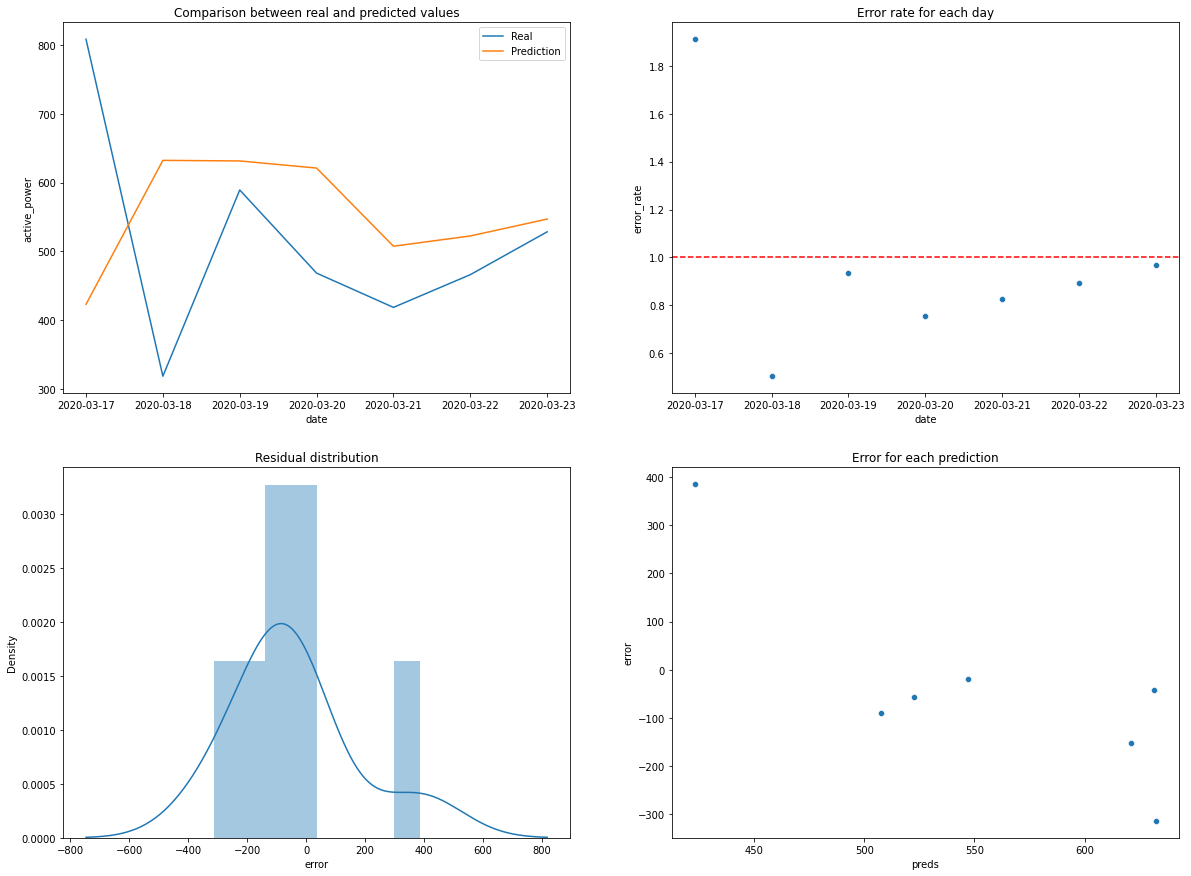

In [258]:
plt.figure(1, figsize=(20,15))
plt.subplot(2,2,1)
plt.title('Comparison between real and predicted values')
sns.lineplot(df_comp['date'], df_comp['active_power'], label = 'Real')
sns.lineplot(df_comp['date'], df_comp['preds'], label = 'Prediction')
plt.legend()

plt.subplot(2,2,2)
plt.title('Error rate for each day')
sns.scatterplot(df_comp['date'], df_comp['error_rate'])
plt.axhline(1, linestyle='--', color='r')

plt.subplot(2,2,3)
plt.title('Residual distribution')
sns.distplot(df_comp['error'])

plt.subplot(2,2,4)
plt.title('Error for each prediction')
sns.scatterplot(df_comp['preds'], df_comp['error'])

After select the best model, we use the predictions to analyze the performance of the model. In the graphic above, it is depicted the error for the predictions. The first subplot (Date x Real Values/Predictions) shows that the model is able to use the available data from the last 7 days to predict the trend of the active power for the next week. However, since the data is very noisy, it will no perform well to detect the peaks. 


Most of errors are distributed in a normal distribution, but with high variance.

In [261]:
preds = final_model.predict(X_test.tail(7)[rfe_selected_features])

last_pred = X_val[['date']].tail(7) + datetime.timedelta(days = 7)
last_pred['predictions'] = mms.inverse_transform(preds.reshape(-1, 1))
last_pred['upper_bound'] = last_pred['predictions'] + 161
last_pred['lower_bound'] = last_pred['predictions'] - 161

In [262]:
last_pred

,date,predictions,upper_bound,lower_bound
814,2020-03-31 00:00:00+00:00,423.021022,584.021022,262.021022
815,2020-04-01 00:00:00+00:00,632.357621,793.357621,471.357621
816,2020-04-02 00:00:00+00:00,631.530111,792.530111,470.530111
817,2020-04-03 00:00:00+00:00,621.163586,782.163586,460.163586
818,2020-04-04 00:00:00+00:00,507.507454,668.507454,346.507454
819,2020-04-05 00:00:00+00:00,522.449177,683.449177,361.449177
820,2020-04-06 00:00:00+00:00,546.969486,707.969486,385.969486


Finally, the predictions for the next 7 days have a variation of 161 kW (positive or negative) for each day. This information can be useful to the client knows if the windmill is working properly.

In [263]:
last_pred.dtypes

date           datetime64[ns, UTC]
predictions                float64
upper_bound                float64
lower_bound                float64
dtype: object

## 10.0 Deploy to Production

The deploy are running locally. I choose to use SQLITE to store data, where I can create two tables, one for the historical data and other for the forecasts. Also, the data visualization is displayed in Metabase.


In [ ]:
import sqlite3
from sqlalchemy import create_engine

In [ ]:
# Connection with the database
conn = sqlite3.connect('windmill_db.sqlite')

In [ ]:
# Run locally
create_engine('sqlite:///windmill_db.sqlite')

### 10.2 Create Historical Table

In [ ]:
# Query to create the historical table
query_create_table_historical = """
        CREATE TABLE historical(
        Date                             TEXT,
        ActivePower                      REAL,
        AmbientTemperatue                REAL,
        BearingShaftTemperature          REAL,
        Blade1PitchAngle                 REAL,
        Blade2PitchAngle                 REAL,
        Blade3PitchAngle                 REAL,
        ControlBoxTemperature            REAL,
        GearboxBearingTemperature        REAL,
        GearboxOilTemperature            REAL,
        GeneratorRPM                     REAL,
        GeneratorWinding1Temperature     REAL,
        GeneratorWinding2Temperature     REAL,
        HubTemperature                   REAL,
        MainBoxTemperature               REAL,
        NacellePosition                  REAL,
        ReactivePower                    REAL,
        RotorRPM                         REAL,
        TurbineStatus                    REAL,
        WTG                              TEXT,
        WindDirection                    REAL,
        WindSpeed                        REAL
        )

"""

### 10.3 Create the Forecast Table

In [ ]:
# Query to create forecast table
query_create_table_forecast = """
        CREATE TABLE forecast (
        date                 REAL,
        predictions          REAL,
        upper_bound          REAL,
        lower_bound          REAL
        )

"""

In [ ]:
# Execute the query
#conn.execute(query_create_table_forecast)

In [ ]:
# Commit
#conn.commit()

In [ ]:
# Execute the query
#conn.execute(query_create_table_historical)

In [ ]:
# Commit
#conn.commit()

### 10.4 Insert Data Into DB

In [ ]:
# Insert the last preds to the database
last_pred.to_sql('forecast', con = conn, if_exists = 'replace', index = False )

In [ ]:
#df0.rename(columns={'Unnmaed: 0': 'Date'})

In [ ]:
# Insert the historical data to the database
df0.to_sql('historical', con = conn, if_exists = 'replace', index = False )

### 10.5 Consult the Database

In [ ]:
# Query to consult the forecasts
query_forecast = """
        SELECT * from forecast

"""

In [ ]:
# Query to consult the historical date (pay attention to the filters if necessary)
query_historical = """
SELECT * from historical

"""

In [ ]:
# Read SQL to CSV
pd.read_sql_query(query_historical, conn)

In [ ]:
# Read SQL to CSV
pd.read_sql_query(query_forecast, conn)

In [ ]:
# Close the database
conn.close()

## 11.0 Data Visualization

In this section, I will demonstrate the visualization by using Metabase. The whole pipeline of the previous section was executed locally and I store the result in a SQLITE database. Then, I choose some metrics for the client monitor to monitor and know if the windmill is running well. Finally, the predictions for 7 days ahead is showed.

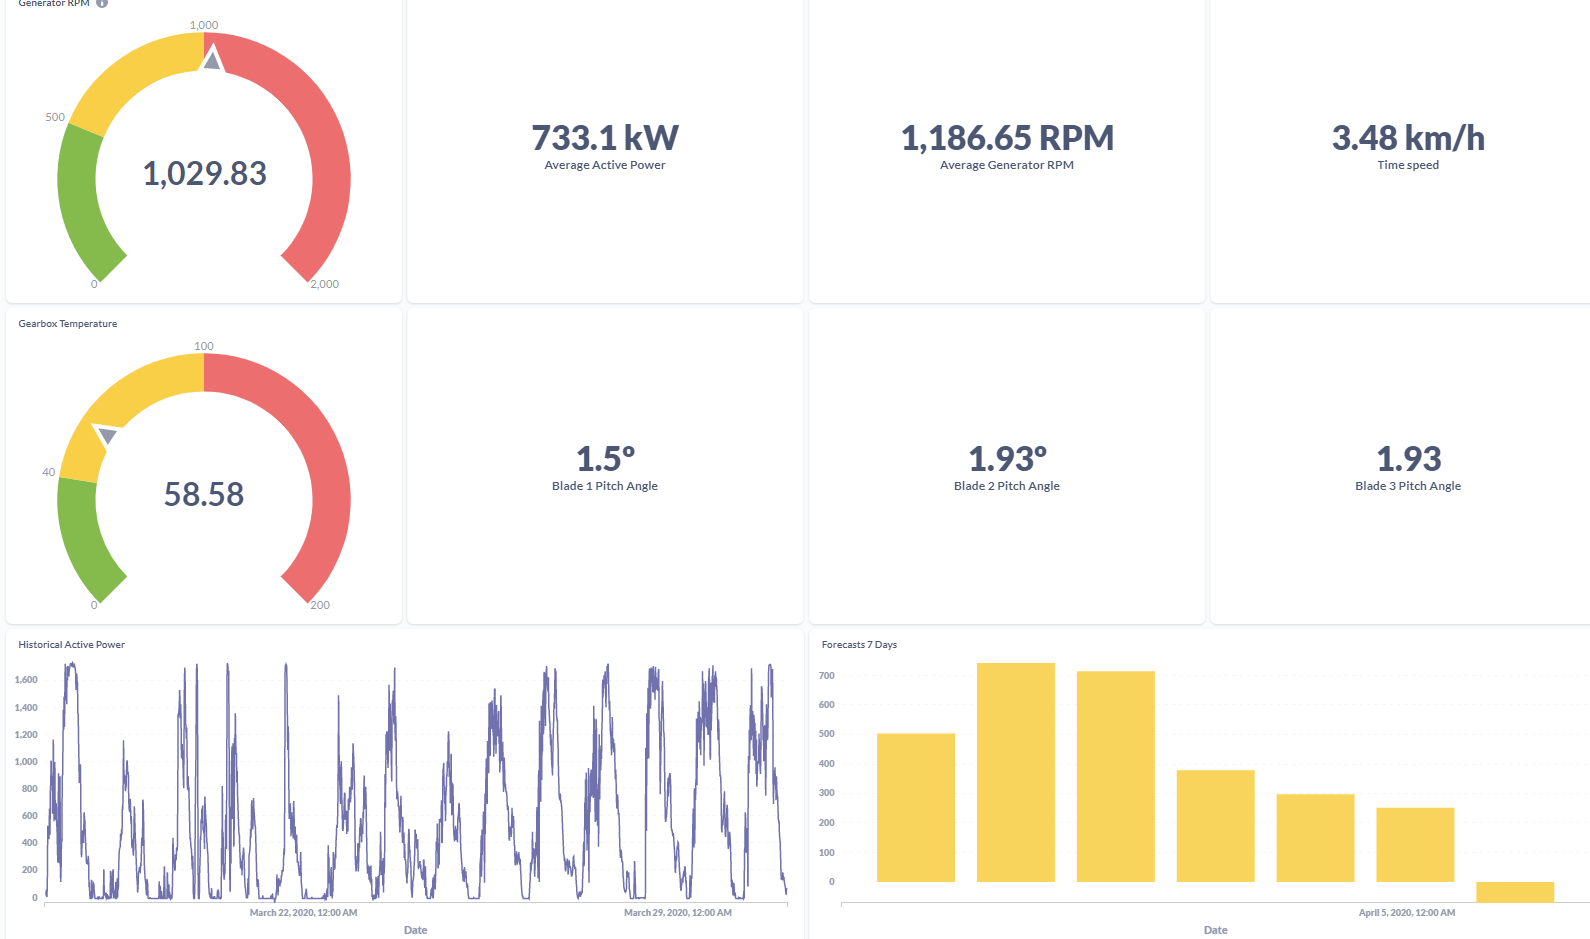

In [4]:
Image('../images/metabase.PNG')